In [ ]:
!pip install igraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 37.4 MB/s eta 0:00:00


In [ ]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
from igraph import Graph
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community.quality import modularity
from scipy.stats import linregress

## 1. Generating Random Networks

###Question 1(a)
Create undirected random networks with n = 900 nodes, and the probability p for drawing an edge between two arbitrary vertices 0.002, 0.006, 0.012, 0.045, and 0.1. Plot the degree distributions. What distribution (linear/exponential/gaussian/binomial or something else) is observed? Explain why. Also, report the mean and variance of the degree distributions and compare them to the theoretical values.

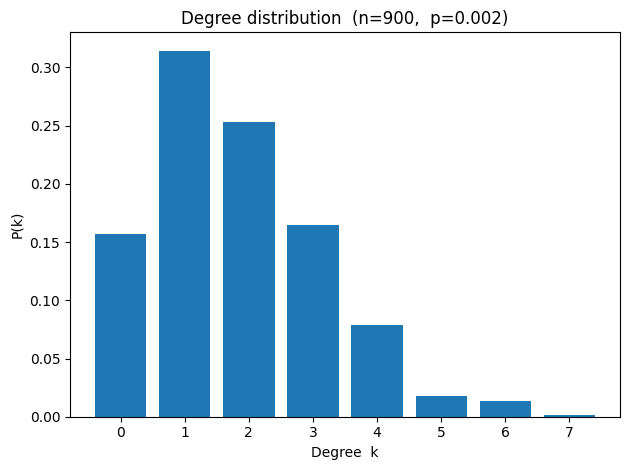

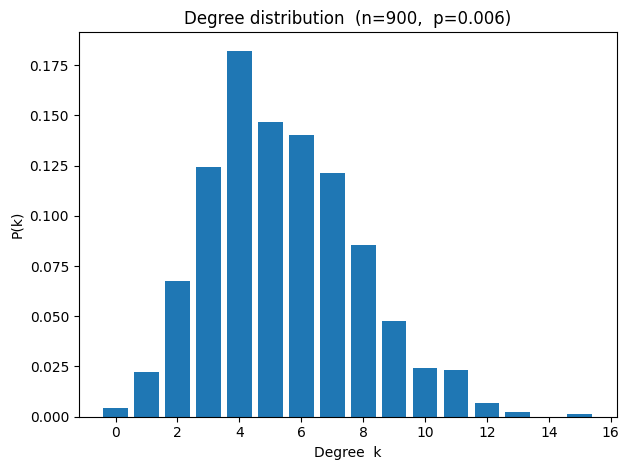

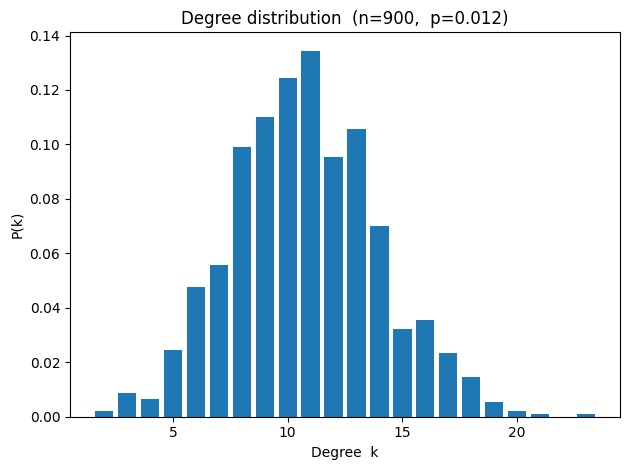

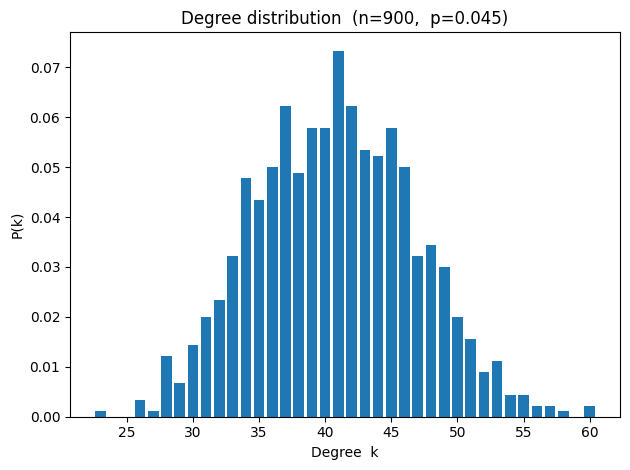

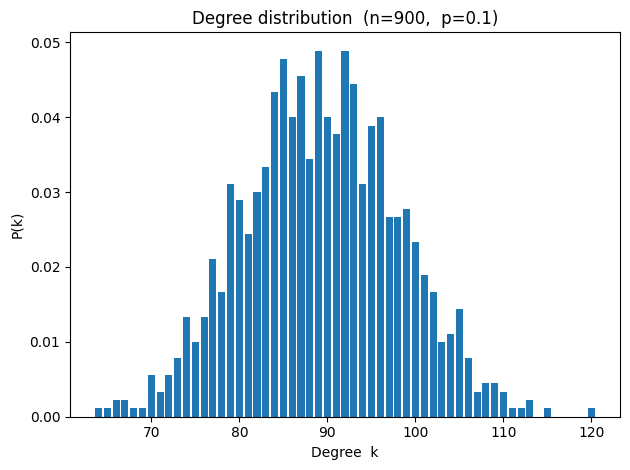

In [ ]:
# -- parameters ------------------------------------------------
n        = 900
p_values = [0.002, 0.006, 0.012, 0.045, 0.1]
# -------------------------------------------------------------

results = []           # to collect statistics for the final table

for p in p_values:
    # 1) generate the graph
    g = ig.Graph.Erdos_Renyi(n=n, p=p, directed=False, loops=False)
    deg = g.degree()

    # 2) empirical statistics
    emp_mean = np.mean(deg)
    emp_var  = np.var(deg, ddof=0)

    # 3) theoretical Binomial moments
    theo_mean = (n - 1) * p
    theo_var  = (n - 1) * p * (1 - p)

    results.append(
        [p, emp_mean, theo_mean, emp_var, theo_var]
    )

    # 4) plot the degree histogram
    plt.figure()
    plt.hist(deg,  bins=range(min(deg), max(deg)+2), align='left', rwidth=0.8, density=True)
    plt.title(f"Degree distribution  (n={n},  p={p})")
    plt.xlabel("Degree  k")
    plt.ylabel("P(k)")
    plt.tight_layout()
    plt.show()

In the context of random graphs, the degree of a node follows a **binomial distribution**. Each edge between the chosen node and any of the other $(n-1)$ nodes appears independently with probability $P$, while the probability of an edge not appearing is $( 1 - p )$. Since these edge choices are made independently, the degree distribution can be expressed as:

$P(\text{degree}(v) = k) = \binom{n-1}{k} p^k (1 - p)^{n-1-k} $

This confirms that the degree of a node follows a binomial distribution:

$\text{degree} \sim B(n - 1, p) $

Furthermore, when the probability $P$ is very small and the number of nodes $n$ is very large—such that the expected degree $ \lambda = np $ remains moderate—the binomial distribution can be well-approximated by a **Poisson distribution**:

$P(\text{degree}(v) = k) = \frac{(np)^k e^{-np}}{k!} $

In [ ]:
# Empirical vs. Theoretical moments Table
# -----------------------------------------------------------------
df = pd.DataFrame(
    results,
    columns=["p",
             "Empirical mean", "Theoretical mean",
             "Empirical var",  "Theoretical var"]
)

print("\n=== Empirical vs. Theoretical Degree Moments ===")
print(df.to_string(index=False))


=== Empirical vs. Theoretical Degree Moments ===
    p  Empirical mean  Theoretical mean  Empirical var  Theoretical var
0.002        1.806667             1.798       1.784844         1.794404
0.006        5.422222             5.394       5.768395         5.361636
0.012       10.766667            10.788      10.345556        10.658544
0.045       40.733333            40.455      36.211111        38.634525
0.100       89.315556            89.900      76.529314        80.910000


### Question 1(b)
For each p and n= 900, answer the following questions:
Are all random realizations of the ER network connected? Numerically estimate the probability that a generated network is connected. For one instance of the networks with that p, find the giant connected component (GCC) if not connected. What is the diameter of the GCC?

In [ ]:
# ------------------------------------------------------------
# Part (b) – Connectivity and GCC statistics for ER graphs
# ------------------------------------------------------------
import igraph as ig
import numpy as np
import pandas as pd

# --- parameters ------------------------------------------------
n           = 900
p_values    = [0.002, 0.006, 0.012, 0.045, 0.1]
n_trials    = 1200
# ---------------------------------------------------------------

records = []

for p in p_values:
    # ---- Monte‑Carlo loop ------------------------------------
    n_connected = 0
    first_graph = None

    for t in range(n_trials):
        g = ig.Graph.Erdos_Renyi(n=n, p=p, directed=False, loops=False)
        if t == 0:                     # keep the first graph as base case
            first_graph = g
        if g.is_connected():           # count how many are connected
            n_connected += 1

    prob_connected = n_connected / n_trials

    # ---- GCC & diameter on the stored example graph ----------
    if first_graph.is_connected():
        gcc = first_graph              # the whole graph is the GCC
    else:
        gcc = first_graph.components().giant()

    gcc_order = gcc.vcount()
    gcc_size  = gcc.ecount()
    gcc_diam  = gcc.diameter()

    # ---- store results ---------------------------------------
    records.append({
        "P": p,
        "Prob_connected": prob_connected,
        "Is_connected": first_graph.is_connected(),
        "Diameter_GCC": gcc_diam,
        "Nodes_in_GCC": gcc_order,
        "Edges_in_GCC": gcc_size,
    })

# ---- display as a DataFrame ----------------------------------
df = pd.DataFrame(records)
print("\n=== GCC information for ER graphs (n = 900) ===")
print(df.to_string(index=False))


=== GCC information for ER graphs (n = 900) ===
    P  Prob_connected  Is_connected  Diameter_GCC  Nodes_in_GCC  Edges_in_GCC
0.002          0.0000         False            26           655           736
0.006          0.0125         False             8           895          2453
0.012          0.9775          True             6           900          4919
0.045          1.0000          True             3           900         18410
0.100          1.0000          True             3           900         40606


To estimate the probability of the ER network being connected, we apply 1200 runs and get the probability of these running results being connected. From the atble above, we could see that When $P$ exceeds 0.012, an ER graph on 900 nodes is almost certainly connected. For values of $P$ below roughly 0.006, the chance of getting a connected graph is very low. As $P$ increases, the diameter of the giant connected component (GCC) shrinks, and once the graph becomes connected the GCC coincides with the entire network.

### Question 1 (c)
For n= 900, sweep over values of p from 0 to a pmax that makes the network almost surely connected and create 100 random networks for each p. pmax should be roughly determined by yourself. Then scatter plot the normalized GCC sizes vs p. Plot a line of the average normalized GCC sizes for each p along with the scatter plot.

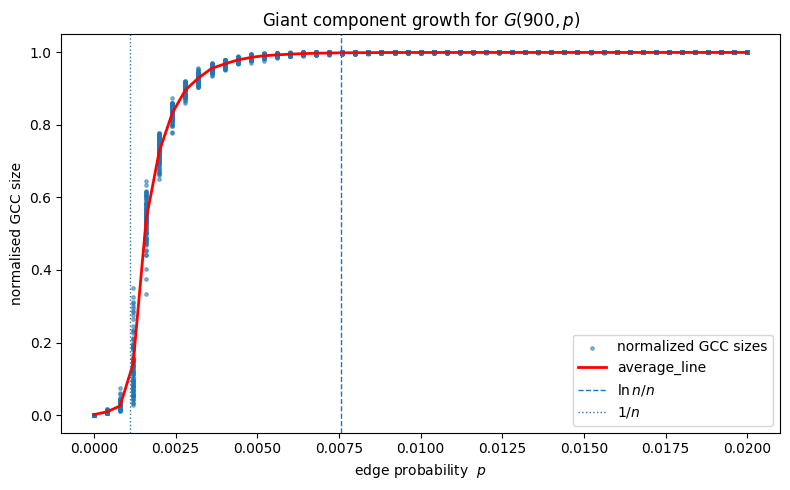

In [ ]:
# --- parameters -------------------------------------------------
n            = 900
n_runs       = 100          # graphs per p
p_grid       = np.linspace(0, 0.02, 51)   # 0 … 0.02 ≈ 2 × ln n / n
# ----------------------------------------------------------------

# allocate: rows = p values, cols = runs
gcc_frac = np.empty((p_grid.size, n_runs))

for i, p in enumerate(p_grid):
    for j in range(n_runs):
        g   = ig.Graph.Erdos_Renyi(n=n, p=p, directed=False, loops=False)
        gcc = g.components().giant()
        gcc_frac[i, j] = gcc.vcount() / n          # normalised GCC size

# --- plotting ---------------------------------------------------
plt.figure(figsize=(8,5))
plt.scatter(np.repeat(p_grid, n_runs), gcc_frac.ravel(), s=6, alpha=0.5,label="normalized GCC sizes")
plt.plot(p_grid, gcc_frac.mean(axis=1), lw=2, color = 'r', label="average_line")

plt.axvline(np.log(n)/n, ls="--", lw=1, label=r"$\ln n / n$")
plt.axvline(1/n,           ls=":",  lw=1, label=r"$1/n$")

plt.xlabel("edge probability  $p$")
plt.ylabel("normalised GCC size")
plt.title("Giant component growth for $G(900,p)$")
plt.legend()
plt.tight_layout()
plt.show()

We define the $P_{max}$ as 0.02, where the network is almost surely connected. so we set the x-axis

i. Empirically estimate the value of pwhere a giant connected component starts to emerge (define your criterion of “emergence”)? Do they match with theoretical values mentioned or derived in lectures? \\
**Answer:**

The giant component is considered to emerge at the first edge-probability p where a tiny increase in p triggers a sharp rise in the normalised GCC size—the “knee” of the growth curve. In our simulations the curve stays nearly flat until $p \approx 0.001$, after which the slope increases dramatically, so the empirical emergence point is $p \approx 0.001$. Theory predicts that an Erdős-Rényi graph with n=900 develops its giant component at $ p_{\text{crit}}=\frac{1}{n}=\frac{1}{900} \approx 0.00111 $; the empirical value therefore aligns almost perfectly with the 1/n threshold anticipated in the lectures.

ii. Empirically estimate the value of p where the giant connected component takes up over 99% of the nodes in almost every experiment. \\
**Answer:**
From empircial graph, we can find that when p is larger than 0.0075, 99% of the nodes in almost every  experiment is connected. This value is in agreement with the theoretical value $ O(\frac{\ln n}{n})$, which is 0.0076.

### Question 1(d)
i. Define the average degree of nodes c = n × p = 0.5. Sweep over the number of
nodes, n, ranging from 100 to 10000. Plot the expected size of the GCC of ER
networks with n nodes and edge-formation probabilities p= c/n, as a function
of n. What trend is observed? \\
ii. Repeat the same for c= 1. \\
iii. Repeat the same for values of c= 1.15,1.25,1.35, and show the results for these three values in a single plot. \\
iv. What is the relation between the expected GCC size and n in each case? \\

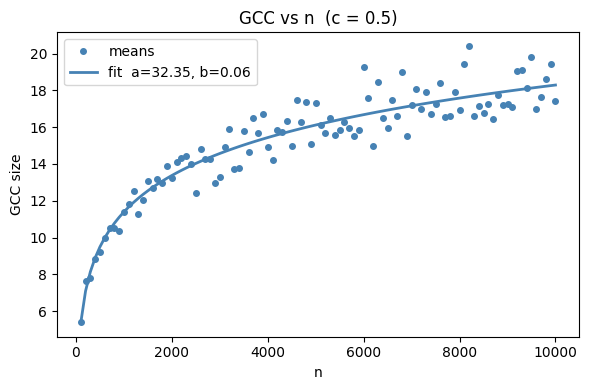

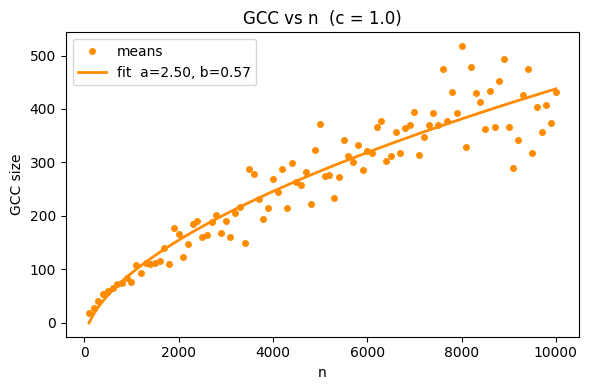

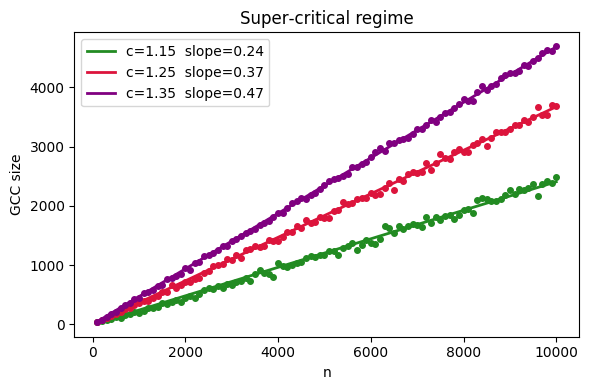

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from igraph import Graph
from scipy.optimize import curve_fit

# -------- parameters ------------------------------------------
n_grid   = np.arange(100, 10_001, 100)   # 100 … 10 000
c_list   = [0.5, 1.0, 1.15, 1.25, 1.35]
runs     = 20
show_scatter = False        # set True to display every sample
rng_seed = 1
np.random.seed(rng_seed)
# --------------------------------------------------------------

# -------- allocate results: rows = n, cols = runs -------------
results = {c: np.empty((n_grid.size, runs)) for c in c_list}

# -------- simulation loop -------------------------------------
for i, n in enumerate(n_grid):
    for c in c_list:
        p = c / n
        for j in range(runs):
            g   = Graph.Erdos_Renyi(n=n, p=p, directed=False, loops=False)
            gcc = g.components().giant().vcount()
            results[c][i, j] = gcc

# -------- helper models ---------------------------------------
def power_law(n, a, b, c):
    return a * n**b + c          # good for c ≤ 1

def linear(n, s):
    return s * n                 # good for c > 1

# -------- (i) & (ii)  c = 0.5  and  c = 1.0 -------------------
for c, colour in zip([0.5, 1.0], ["steelblue", "darkorange"]):
    y_mean = results[c].mean(axis=1)
    popt, _ = curve_fit(power_law, n_grid, y_mean, p0=[1, 0.7, 0])

    plt.figure(figsize=(6,4))
    if show_scatter:
        plt.scatter(np.repeat(n_grid, runs), results[c].ravel(),
                    s=10, alpha=0.4, label="samples")
    plt.plot(n_grid, y_mean, "o", ms=4, label="means", color=colour)
    plt.plot(n_grid, power_law(n_grid, *popt), lw=2, color=colour,
             label=f"fit  a={popt[0]:.2f}, b={popt[1]:.2f}")
    plt.xlabel("n"); plt.ylabel("GCC size")
    plt.title(f"GCC vs n  (c = {c})")
    plt.legend(); plt.tight_layout(); plt.show()

# -------- (iii)  super‑critical cases on one axis --------------
plt.figure(figsize=(6,4))
for c, colour in zip([1.15, 1.25, 1.35], ["forestgreen", "crimson", "purple"]):
    y_mean = results[c].mean(axis=1)
    popt, _ = curve_fit(linear, n_grid, y_mean)   # slope s ≈ giant‑component fraction
    if show_scatter:
        plt.scatter(np.repeat(n_grid, runs), results[c].ravel(),
                    s=10, alpha=0.3, color=colour)
    plt.plot(n_grid, y_mean, "o", ms=4, color=colour)
    plt.plot(n_grid, linear(n_grid, *popt), lw=2, color=colour,
             label=f"c={c}  slope={popt[0]:.2f}")

plt.xlabel("n"); plt.ylabel("GCC size")
plt.title("Super‑critical regime")
plt.legend(); plt.tight_layout(); plt.show()

**Answer:**

First figure (c = 0.5) The curve hugs the bottom: the GCC grows slower than any power of n (fragmented regime). \\

Second figure (c = 1.0) A noticeable but sub-linear rise—at criticality the GCC scales like $n^{2/3}$. \\

Third figure (c = 1.15, 1.25, 1.35) Three straight lines whose slopes increase with c; in the super-critical phase the expected GCC size is linear in n with proportionality S(c) (solution of $S=1-e^{-cS}$).

### Question 2(a)
Create an undirected network with n = 1050 nodes, with preferential attachment model, where each new node attaches to m= 1 old nodes. Is such a network always connected?

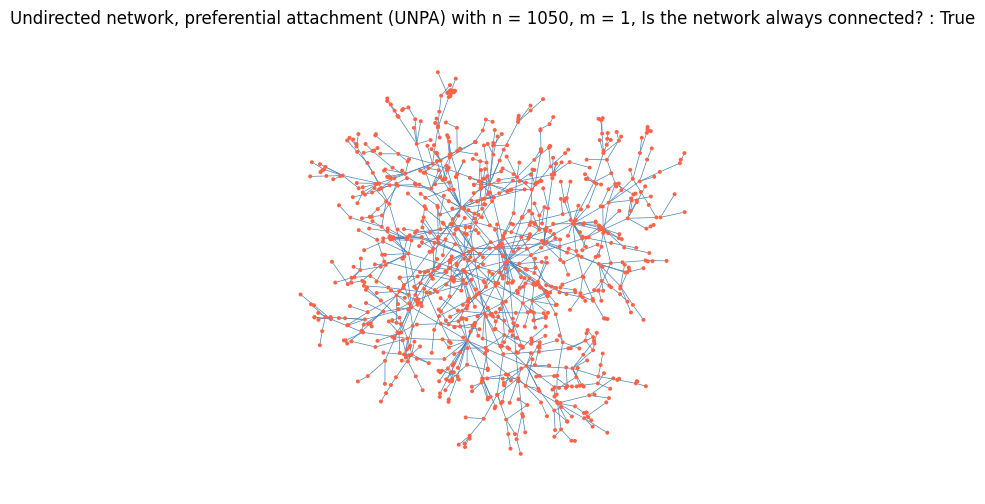

In [ ]:
g = ig.Graph(n=1050)
g = g.Barabasi(n=1050, m=1,directed=False)
layout = g.layout("fr")

fig, ax = plt.subplots(figsize=(6,6))
ax.set_title(f"Undirected network, preferential attachment (UNPA) with n = 1050, m = 1, Is the network always connected? : {g.is_connected()}")

ig.plot(
     g,
  target=ax,
  layout=layout,
  vertex_size=4,
  vertex_color="tomato",
  vertex_frame_width=0,
  edge_color="steelblue",
  edge_width=0.5,
  bbox=(700, 700),
  margin=25,
)
plt.show()



The Network(UNPA) is always connected

### Question 2(b)
Use fast greedy method to find the community structure. Measure modularity. Define Assortativity. Compute Assortativity.

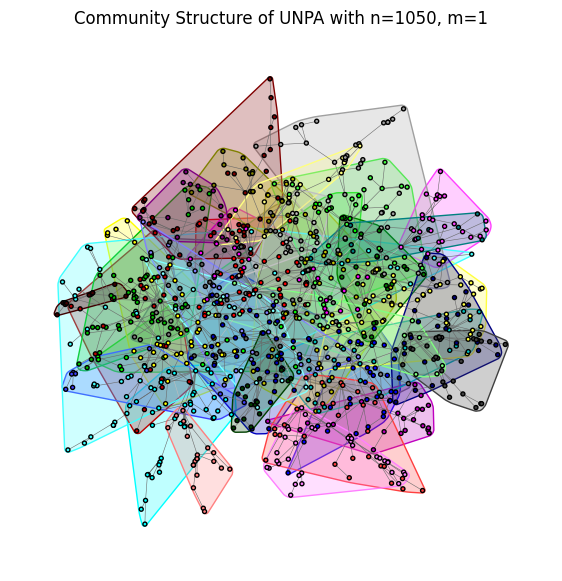

Modularity (Fast‑Greedy): 0.9338
Degree assortativity r  : -0.0603


In [ ]:
# --- Fast‑Greedy community detection ---------------------
fg = g.community_fastgreedy()
comms = fg.as_clustering()

# --- plotting --------------------------------------------
layout = g.layout("fr")
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_title(f"Community Structure of UNPA with n=1050, m=1")
ax.set_axis_off()
ig.plot(
    comms,
    target=ax,
    layout=layout,
    vertex_size=4,
    edge_width=0.4,
    mark_groups=True,
    palette=ig.drawing.colors.ClusterColoringPalette(len(comms)),
    bbox=(700, 700),
    margin=25,
)
plt.show()

# --- metrics ---------------------------------------------
Q = g.modularity(comms)             # modularity
r = g.assortativity_degree()        # degree assortativity
print(f"Modularity (Fast‑Greedy): {Q:.4f}")
print(f"Degree assortativity r  : {r:.4f}")

**Assortativity** quantifies how likely nodes with similar degrees are to connect with each other in a network.  
Its value lies between −1 and 1:

- **r ≈ 1** — Strong assortativity: high-degree nodes tend to connect with other high-degree nodes, and low-degree nodes with low-degree ones.  
- **r ≈ -1** — Strong disassortativity: high-degree nodes are more likely to connect with low-degree nodes.

The assortativity coefficient is defined as:

$
r = \frac{\sum_i e_{ii} - \sum_i a_i b_i}
         {1 - \sum_i a_i b_i},
$

where:

- $e_{ij}$ is the fraction of edges between nodes of degree class $i$ and degree class $j$,
- $a_i = \sum_j e_{ij}$ and $b_j = \sum_i e_{ij}$ are the marginal distributions of the degrees at either end of an edge.

we have Modularity: 0.9338, and Assortativity: -0.0603

### Quetion 2(c)
Try to generate a larger network with 10500 nodes using the same model.Compute modularity and assortativity. How is it compared to the smaller network's modularity?

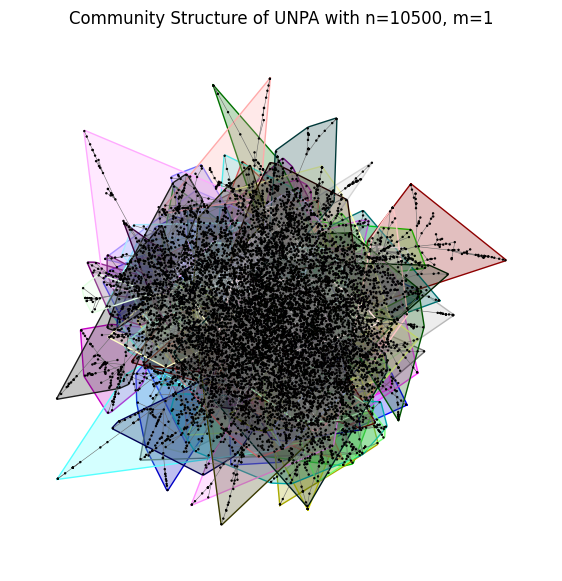

In [ ]:
g_large = ig.Graph(n=10500)
g_large = g.Barabasi(n=10500, m=1,directed=False)

# --- Fast‑Greedy community detection ---------------------
fg = g_large.community_fastgreedy()
comms = fg.as_clustering()

# --- plotting --------------------------------------------
layout = g_large.layout("fr")
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_title(f"Community Structure of UNPA with n=10500, m=1")
ax.set_axis_off()
ig.plot(
    comms,
    target=ax,
    layout=layout,
    vertex_size=1,
    edge_width=0.4,
    mark_groups=True,
    palette=ig.drawing.colors.ClusterColoringPalette(len(comms)),
    bbox=(700, 700),
    margin=25,
)
plt.show()

In [ ]:
# --- metrics ---------------------------------------------
Q = g_large.modularity(comms)             # modularity
r = g_large.assortativity_degree()        # degree assortativity
print(f"Modularity (Fast‑Greedy): {Q:.4f}")
print(f"Degree assortativity r  : {r:.4f}")

Modularity (Fast‑Greedy): 0.9784
Degree assortativity r  : -0.0314


The bigger graph shows a higher modularity than the smaller one. As the node count rises, more high-degree hubs appear and the number of densely knit groups increases, boosting the modularity score. At the same time, the added size makes the network's architecture richer and more varied, so the underlying community pattern becomes harder to pin down even though, mathematically, the partitioning algorithm can extract a larger total modularity.

### Quetion 2(d)

Slope for n=1050 (tail only): -2.28
Slope for n=10500 (tail only): -2.64


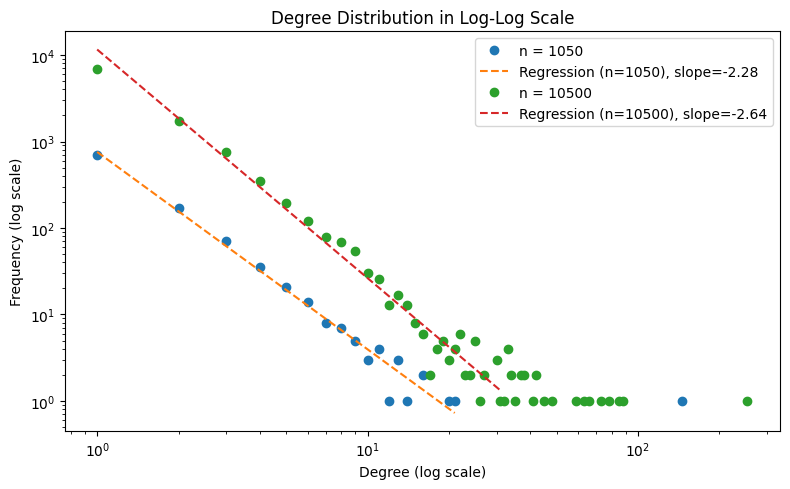

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

def create_pa_network(n, m):
    return nx.barabasi_albert_graph(n, m)

def plot_degree_distribution_loglog(G, label):
    degrees = dict(G.degree())
    degree_values = sorted(set(degrees.values()))
    degree_counts = [list(degrees.values()).count(deg) for deg in degree_values]

    # Log-log scatter
    plt.loglog(degree_values, degree_counts, 'o', label=label)

    return np.array(degree_values), np.array(degree_counts)

# Parameters
n_values = [1050, 10500]
m = 1
degree_cutoff = 31  # <- only fit degrees >= this value
slopes = []

# Plot setup
plt.figure(figsize=(8, 5))

for n in n_values:
    G = create_pa_network(n, m)
    degree_values, degree_counts = plot_degree_distribution_loglog(G, f'n = {n}')

    # Filter to tail: only degrees above cutoff
    tail_mask = (degree_values <= degree_cutoff) & (degree_counts > 0)
    tail_degrees = degree_values[tail_mask]
    tail_counts = degree_counts[tail_mask]

    log_degrees = np.log(tail_degrees)
    log_counts = np.log(tail_counts)

    # Fit regression line to log-log tail
    slope, intercept, _, _, _ = linregress(log_degrees, log_counts)
    slopes.append(slope)

    # Plot regression
    x_fit = np.linspace(min(log_degrees), max(log_degrees), 100)
    y_fit = intercept + slope * x_fit
    plt.plot(np.exp(x_fit), np.exp(y_fit), '--', label=f'Regression (n={n}), slope={slope:.2f}')

# Labels and title
plt.xlabel('Degree (log scale)')
plt.ylabel('Frequency (log scale)')
plt.title(f'Degree Distribution in Log-Log Scale')
plt.legend()
plt.tight_layout()

# Output slopes
for i, n in enumerate(n_values):
    print(f"Slope for n={n} (tail only): {slopes[i]:.2f}")

plt.show()

For the Barabási–Albert model (preferential attachment), the theoretical degree distribution follows a power law:

$P(k) \propto k^{-\gamma}$ For BA networks, $\gamma \approx 3$, which means the slope in log-log space ≈ -3. The theoretical value is 3. By using observsing when degree large than 50, the frequency towards to 10^0, using linear regression may be afftected to fit a nolinear data cluster. The slope should close to the 3.0

### Quetion 2(e)

Sampled neighbor degree slope (n=1050): -1.35
Sampled neighbor degree slope (n=10500): -1.43


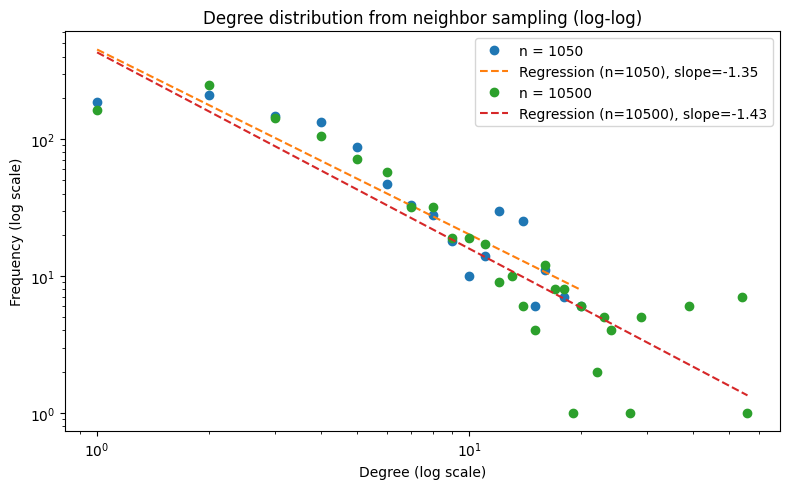

In [ ]:
def plot_new_degree_distribution(m, n, n_sample=1000):
    g = ig.Graph.Barabasi(n=n, m=m, directed=False)

    degs = np.zeros((n_sample,))
    for i in range(n_sample):
        # Pick a random node i
        sample_node = np.random.randint(0, n)
        neighs = g.neighbors(sample_node)

        if len(neighs) == 0:
            continue  # skip isolated nodes (rare)

        # Random neighbor j of node i
        sample_neighbor = np.random.choice(neighs)
        degs[i] = g.degree(sample_neighbor)

    # Frequency count of sampled degrees
    deg_counts = np.bincount(degs.astype(int))
    x = np.arange(len(deg_counts))[deg_counts != 0]
    y = deg_counts[deg_counts != 0]

    # Log-log plot
    plt.loglog(x, y, 'o', label=f'n = {n}')

    # Linear regression in log-log space
    log_x = np.log(x)
    log_y = np.log(y)
    slope, intercept, _, _, _ = linregress(log_x, log_y)
    y_fit = np.exp(intercept + slope * log_x)

    # Regression line
    plt.plot(x, y_fit, '--', label=f'Regression (n={n}), slope={slope:.2f}')

    print(f"Sampled neighbor degree slope (n={n}): {slope:.2f}")

# Plot both networks
plt.figure(figsize=(8, 5))
plot_new_degree_distribution(m=1, n=1050)
plot_new_degree_distribution(m=1, n=10500)
plt.xlabel('Degree (log scale)')
plt.ylabel('Frequency (log scale)')
plt.title('Degree distribution from neighbor sampling (log-log)')
plt.legend()
plt.tight_layout()
plt.show()

The slopes from the sampled neighbor nodes are flatter than those of the full network’s degree distribution. This suggests that the degree distribution of randomly selected neighbors has a lighter tail, indicating fewer extremely high-degree nodes. As a result, the distribution is less skewed and more centered around lower-degree values compared to the overall network.

### Quetion 2(f)


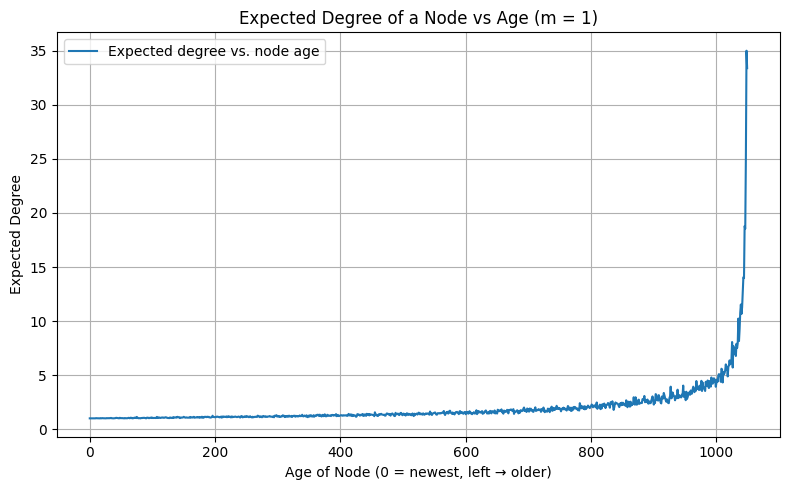

In [ ]:
def plot_relation(m, n=1050, n_trail=100):
    ages = np.zeros((n, 1))

    for _ in range(n_trail):
        # Generate graph
        g = nx.barabasi_albert_graph(n=n, m=m)
        degrees = np.array([deg for _, deg in g.degree()]).reshape(-1, 1)
        ages += degrees

    # Average over trials
    ages /= n_trail

    # Reverse to match age: older nodes (added earlier) have higher indices
    # So age 0 is most recent node, age (n-1) is the oldest
    plt.figure(figsize=(8, 5))
    plt.plot(np.arange(n-1, -1, -1), ages, label="Expected degree vs. node age")
    plt.title(f"Expected Degree of a Node vs Age (m = {m})")
    plt.xlabel("Age of Node (0 = newest, left → older)")
    plt.ylabel("Expected Degree")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Run the simulation
plot_relation(m=1)

The plot clearly shows that the expected degree of a node increases with its age. This observation aligns with the behavior of preferential attachment models, where older nodes have had more opportunities to attract connections from newly added nodes. As a result, they accumulate more edges over time. This pattern is consistent with the theoretical model $k(j, i) = m \sqrt{\frac{i}{j}}$, where j is the time the node was added, i is the current time, and m is the number of edges each new node brings. The plot demonstrates a monotonically increasing curve, confirming that older nodes tend to have higher degrees. This reflects the “rich-get-richer” phenomenon, a defining characteristic of scale-free networks, where nodes that are already well-connected are more likely to receive new connections.

### Quetion 2(g)

m=2

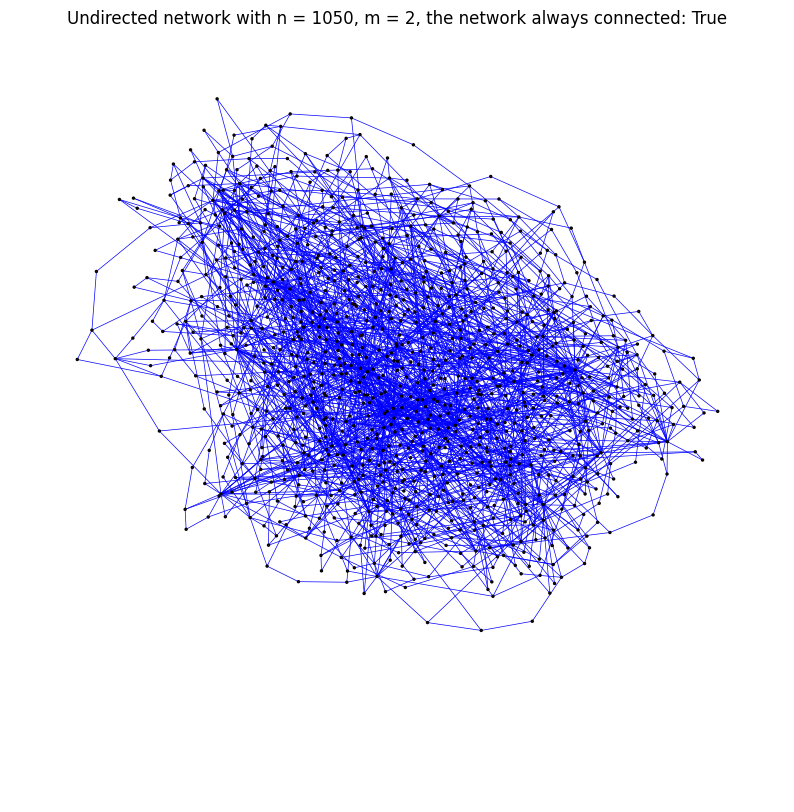

In [ ]:
g = ig.Graph(n=1050)
g = g.Barabasi(n=1050, m=2)
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title(f"Undirected network with n = 1050, m = 2, the network always connected: {g.is_connected()}")
ig.plot(
  g,
  target=ax,
  vertex_color='red',
  edge_color='blue',
  vertex_size=2,
  edge_width=0.5,
)
plt.show()

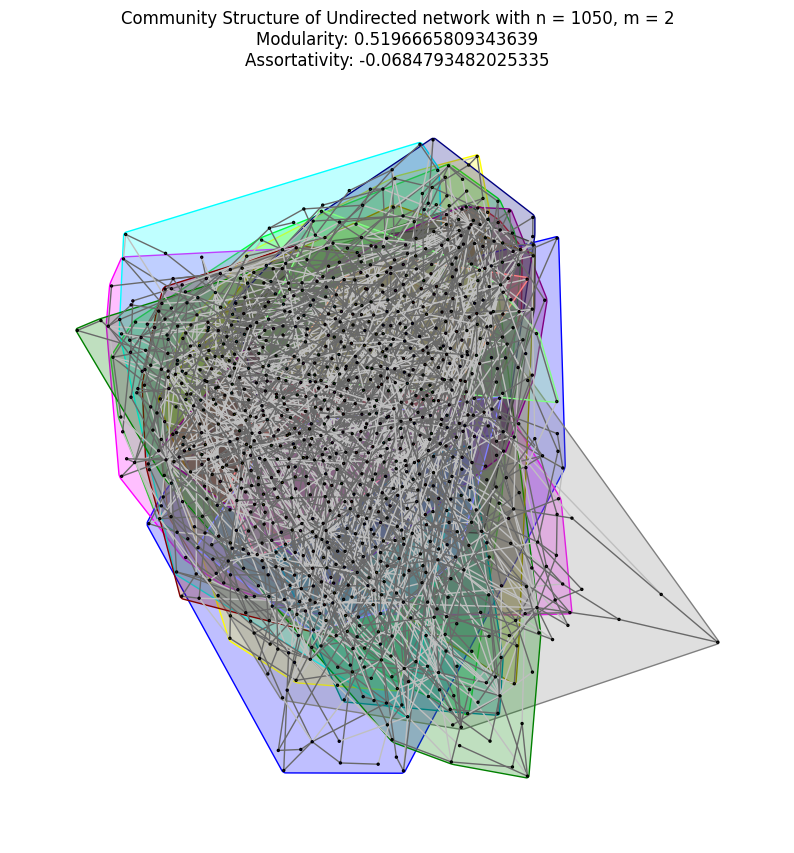

In [ ]:
# m = 2 and n = 1050
fg = g.community_fastgreedy()
communities = fg.as_clustering()

fig, ax = plt.subplots(figsize=(10, 10))

g_modularity = g.modularity(fg.as_clustering())
g_assortativity = g.assortativity_degree()

ax.set_title(f"Community Structure of UNPA with n = 1050, m = 2\n"
             f"Modularity: {g_modularity}\nAssortativity: {g_assortativity}")

ig.plot(
    communities,
    target=ax,
    vertex_size=2,
    edge_width=1,
    mark_groups=True
)
plt.show()

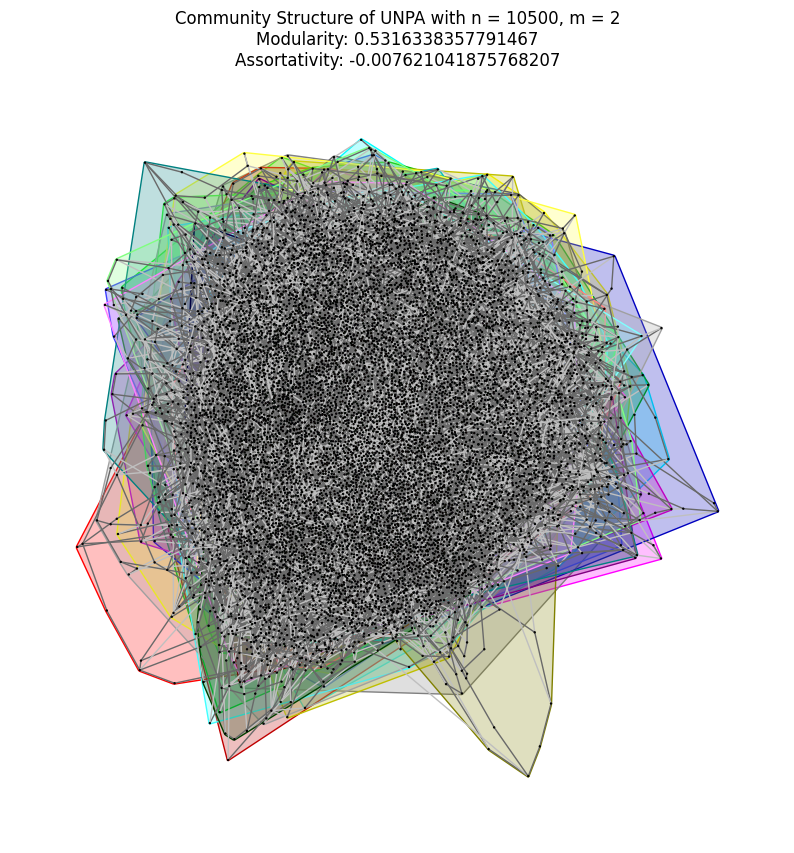

In [ ]:
# m = 2 and n = 10500
g_large = ig.Graph.Barabasi(n=10500, m=2)

# Calculate modularity and assortativity for larger network
fg_large = g_large.community_fastgreedy()
com_large = fg_large.as_clustering()
modularity_large = g_large.modularity(fg_large.as_clustering())
assortativity_large = g_large.assortativity_degree()

# Plot the network
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_title(f"Community Structure of UNPA with n = 10500, m = 2\n"
             f"Modularity: {modularity_large}\nAssortativity: {assortativity_large}")

ig.plot(
    com_large,
    target=ax,
    vertex_size=1.5,
    edge_width=1,
    mark_groups=True
)

plt.show()

Slope for n=1050: -2.2714480953084046
Slope for n=10500: -2.481039046578192


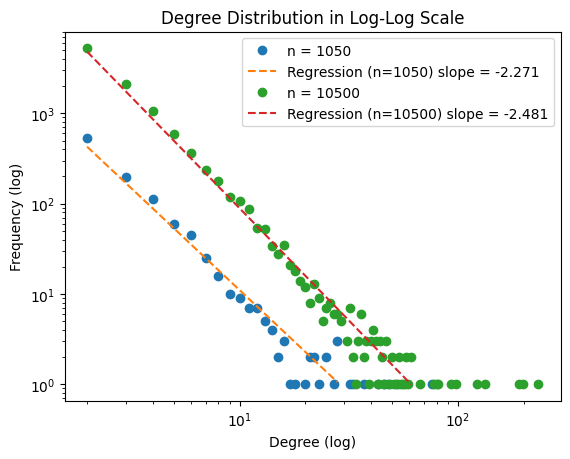

In [ ]:
def create_pa_network(n, m):
    return nx.barabasi_albert_graph(n, m)

def plot_degree_distribution_loglog(G, label):
    degrees = dict(G.degree())
    degree_values = sorted(set(degrees.values()))
    degree_counts = [list(degrees.values()).count(deg) for deg in degree_values]
    plt.loglog(degree_values, degree_counts, 'o', label=label)
    return degree_values, degree_counts

n_values = [1050, 10500]
m = 2
slopes = []

for n in n_values:
    G = create_pa_network(n, m)
    degree_values, degree_counts = plot_degree_distribution_loglog(G, f'n = {n}')

    log_degree_values = np.log(degree_values)
    log_degree_counts = np.log(degree_counts)
    non_zero_idxs = np.nonzero(log_degree_counts)
    log_degree_values = log_degree_values[non_zero_idxs]
    log_degree_counts = log_degree_counts[non_zero_idxs]

    slope, intercept, _, _, _ = linregress(log_degree_values, log_degree_counts)
    slopes.append(slope)

    plt.plot(
        np.exp(log_degree_values),
        np.exp(intercept + slope * log_degree_values),
        '--',
        label=f'Regression (n={n}) slope = {slope:.3f}'
    )

plt.xlabel('Degree (log)')
plt.ylabel('Frequency (log)')
plt.title('Degree Distribution in Log-Log Scale')
plt.legend()

for i, n in enumerate(n_values):
    print(f"Slope for n={n}: {slopes[i]}")

plt.show()

In [ ]:
def plot_new_degree_distribution(m, n, n_sample=1000):
    g = ig.Graph.Barabasi(n=n, m=m, directed=False)
    degs = np.zeros((n_sample, 1))

    for i in range(n_sample):
        sample_node = np.random.randint(0, n)
        neighs = g.neighbors(sample_node)
        sample_neighbor = np.random.choice(neighs, 1)[0]
        degs[i, 0] = g.degree(sample_neighbor)

    deg_dist = np.bincount(degs[:, 0].astype(int))
    x = np.arange(len(deg_dist))[deg_dist != 0]
    y = deg_dist[deg_dist != 0]

    plt.loglog(x, y, 'o', label=f"Degree distribution of n = {n}")

    x = np.log(x)
    y = np.log(y)
    non_zero_idxs = np.nonzero(y)
    x = x[non_zero_idxs]
    y = y[non_zero_idxs]

    slope, intercept, _, _, _ = linregress(x, y)
    log_degree_values = x
    plt.plot(np.exp(log_degree_values), np.exp(intercept + slope * log_degree_values), '--',
             label=f'Regression (n={n}) slope = {slope:.3f}')


plot_new_degree_distribution(m=2, n=1050)
plot_new_degree_distribution(m=2, n=10500)

plt.xlabel('Degree (log)')
plt.ylabel('Frequency (log)')
plt.title(f"Degree distribution of new method")
plt.legend()
plt.show()

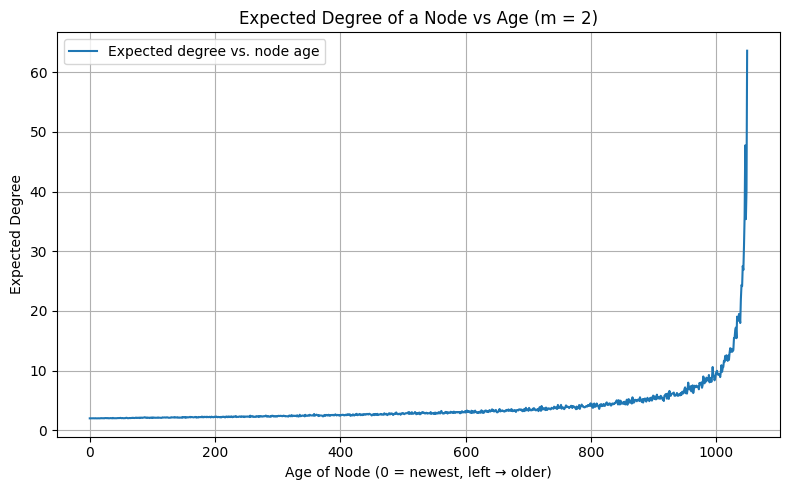

In [ ]:
plot_relation(m=2)

m=6

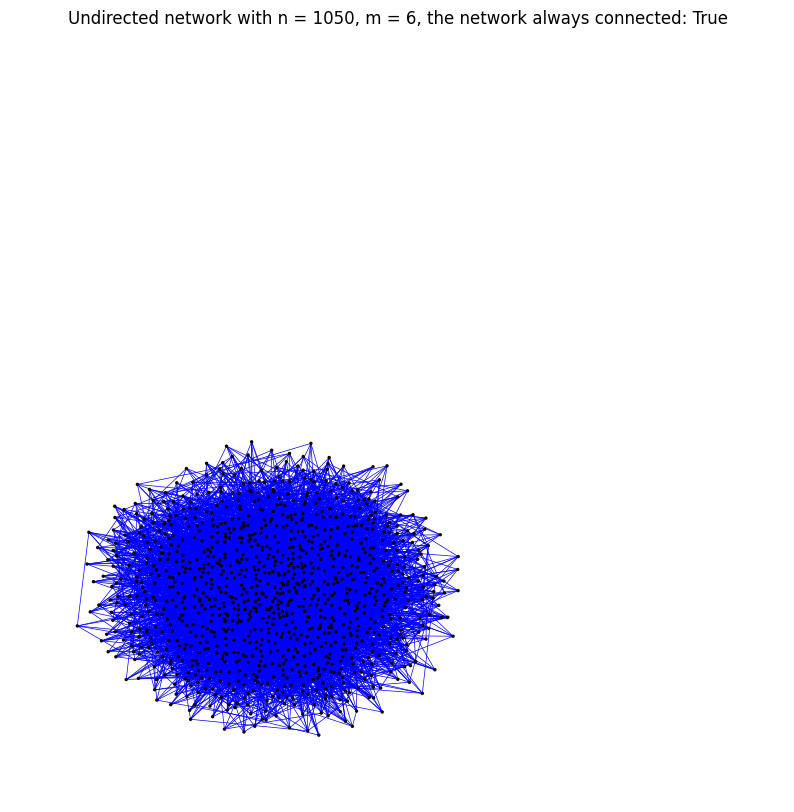

In [ ]:
g = ig.Graph(n=1050)
g = g.Barabasi(n=1050, m=6)

fig, ax = plt.subplots(figsize=(10, 10))

ax.set_title(f"Undirected network with n = 1050, m = 6, the network always connected: {g.is_connected()}")

ig.plot(
    g,
    target=ax,
    vertex_color='red',
    edge_color='blue',
    vertex_size=2,
    edge_width=0.5,
)

plt.show()

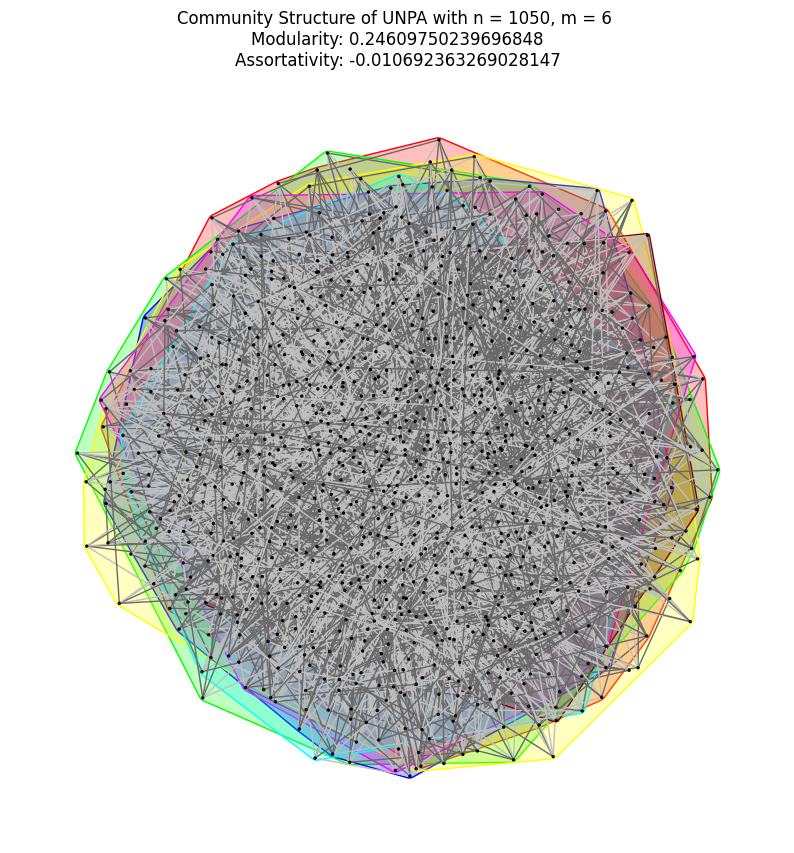

In [ ]:
# m = 6 and n = 1050
fg = g.community_fastgreedy()
communities = fg.as_clustering()

fig, ax = plt.subplots(figsize=(10, 10))

g_modularity = g.modularity(fg.as_clustering())
g_assortativity = g.assortativity_degree()

ax.set_title(f"Community Structure of UNPA with n = 1050, m = 6 \n"
             f"Modularity: {g_modularity}\nAssortativity: {g_assortativity}")

ig.plot(
    communities,
    target=ax,
    vertex_size=2,
    edge_width=1,
    mark_groups=True
)
plt.show()

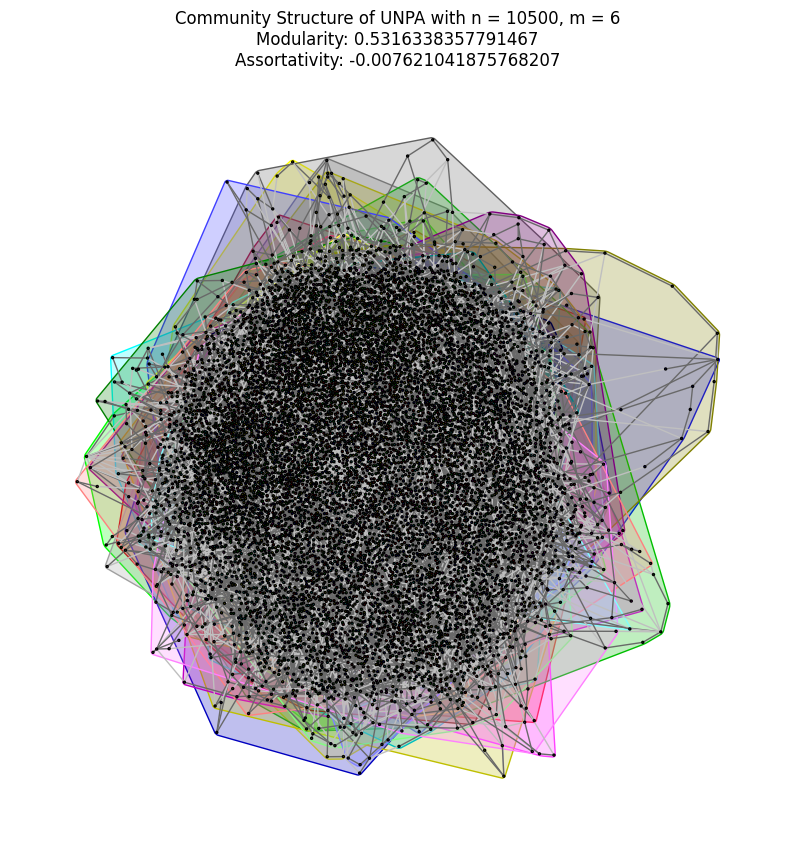

In [ ]:
# Calculate modularity and assortativity for larger network
fg_large = g_large.community_fastgreedy()
com_large = fg_large.as_clustering()
modularity_large = g_large.modularity(fg_large.as_clustering())
assortativity_large = g_large.assortativity_degree()

# Plot the network
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_title(f"Community Structure of UNPA with n = 10500, m = 6\n"
             f"Modularity: {modularity_large}\nAssortativity: {assortativity_large}")

ig.plot(
    com_large,
    target=ax,
    vertex_size=2,
    edge_width=1,
    mark_groups=True
)
plt.show()

Slope for n=1050: -2.2727033742887297
Slope for n=10500: -2.5682088294990604


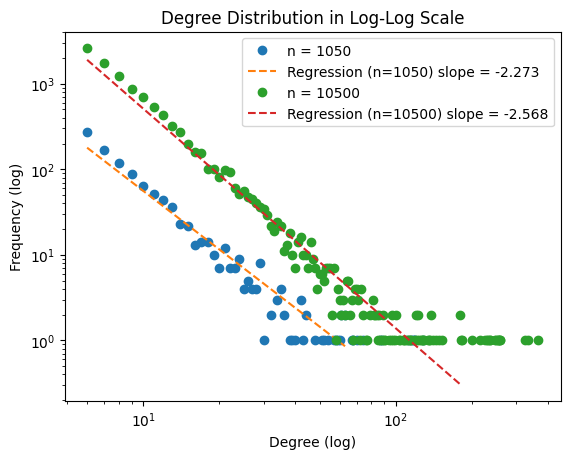

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

def create_pa_network(n, m):
    return nx.barabasi_albert_graph(n, m)

def plot_degree_distribution_loglog(G, label):
    degrees = dict(G.degree())
    degree_values = sorted(set(degrees.values()))
    degree_counts = [list(degrees.values()).count(deg) for deg in degree_values]
    plt.loglog(degree_values, degree_counts, 'o', label=label)
    return degree_values, degree_counts

n_values = [1050, 10500]
m = 6
slopes = []

for n in n_values:
    G = create_pa_network(n, m)
    degree_values, degree_counts = plot_degree_distribution_loglog(G, f'n = {n}')

    log_degree_values = np.log(degree_values)
    log_degree_counts = np.log(degree_counts)
    non_zero_idxs = np.nonzero(log_degree_counts)
    log_degree_values = log_degree_values[non_zero_idxs]
    log_degree_counts = log_degree_counts[non_zero_idxs]

    slope, intercept, _, _, _ = linregress(log_degree_values, log_degree_counts)
    slopes.append(slope)

    plt.plot(
        np.exp(log_degree_values),
        np.exp(intercept + slope * log_degree_values),
        '--',
        label=f'Regression (n={n}) slope = {slope:.3f}'
    )

plt.xlabel('Degree (log)')
plt.ylabel('Frequency (log)')
plt.title('Degree Distribution in Log-Log Scale')
plt.legend()

for i, n in enumerate(n_values):
    print(f"Slope for n={n}: {slopes[i]}")

plt.show()

Slope for n=1050: -2.2143888450129685
Slope for n=10500: -2.554983700326625


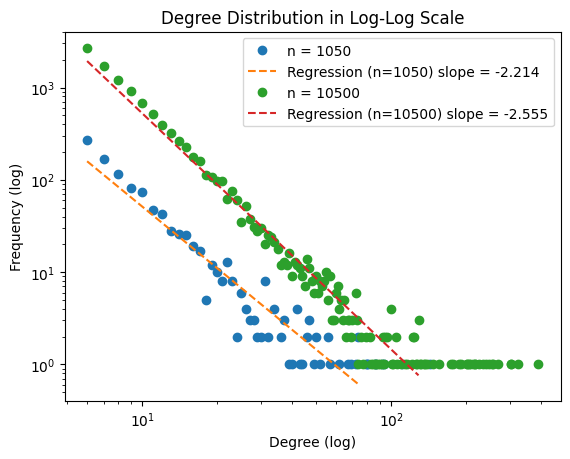

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

def create_pa_network(n, m):
    return nx.barabasi_albert_graph(n, m)

def plot_degree_distribution_loglog(G, label):
    degrees = dict(G.degree())
    degree_values = sorted(set(degrees.values()))
    degree_counts = [list(degrees.values()).count(deg) for deg in degree_values]
    plt.loglog(degree_values, degree_counts, 'o', label=label)
    return degree_values, degree_counts

n_values = [1050, 10500]
m = 6
slopes = []

for n in n_values:
    G = create_pa_network(n, m)
    degree_values, degree_counts = plot_degree_distribution_loglog(G, f'n = {n}')

    log_degree_values = np.log(degree_values)
    log_degree_counts = np.log(degree_counts)
    non_zero_idxs = np.nonzero(log_degree_counts)
    log_degree_values = log_degree_values[non_zero_idxs]
    log_degree_counts = log_degree_counts[non_zero_idxs]

    slope, intercept, _, _, _ = linregress(log_degree_values, log_degree_counts)
    slopes.append(slope)

    plt.plot(
        np.exp(log_degree_values),
        np.exp(intercept + slope * log_degree_values),
        '--',
        label=f'Regression (n={n}) slope = {slope:.3f}'
    )

plt.xlabel('Degree (log)')
plt.ylabel('Frequency (log)')
plt.title('Degree Distribution in Log-Log Scale')
plt.legend()

for i, n in enumerate(n_values):
    print(f"Slope for n={n}: {slopes[i]}")

plt.show()

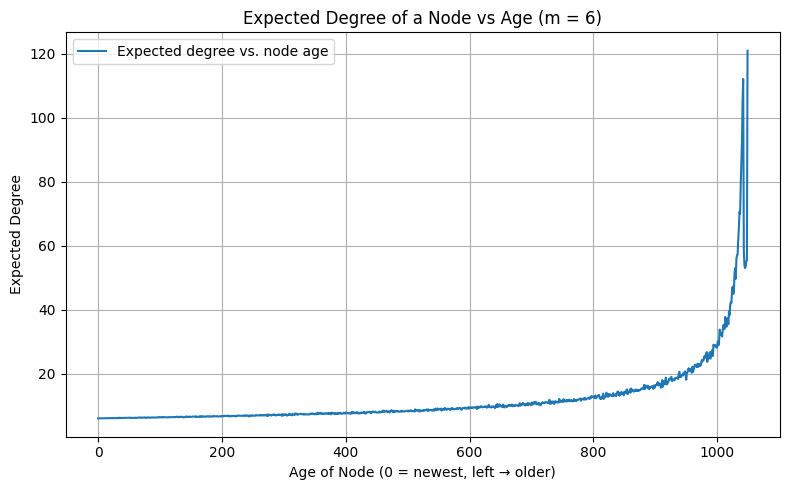

In [ ]:
plot_relation(m=6)

### Quetion 2(h)

Modularity: 0.919


<ipython-input-140-57e313a98c2c>:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', max(groups.values()) + 1)


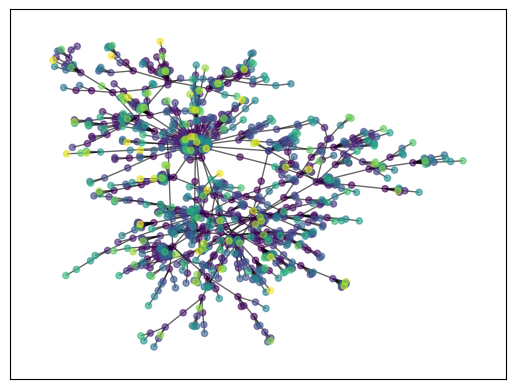

In [ ]:
from networkx.algorithms.community.quality import modularity
from networkx.algorithms.community import greedy_modularity_communities
import networkx as nx
import matplotlib.pyplot as plt

def plot_communities(g):
    communities = greedy_modularity_communities(g)
    groups = dict()
    for i, comm in enumerate(communities):
        for node in comm:
            groups[node] = i

    pos = nx.spring_layout(g, seed=42)
    cmap = plt.cm.get_cmap('viridis', max(groups.values()) + 1)
    nx.draw_networkx(
        g, pos=pos, node_size=20, with_labels=False,
        alpha=0.6, node_color=list(groups.values()), cmap=cmap
    )
    modularity_score = modularity(g, communities)
    print(f"Modularity: {modularity_score:.3f}")

g = nx.barabasi_albert_graph(1050, m=1, seed=42)
plot_communities(g)

Modularity: 0.825


<ipython-input-140-57e313a98c2c>:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', max(groups.values()) + 1)


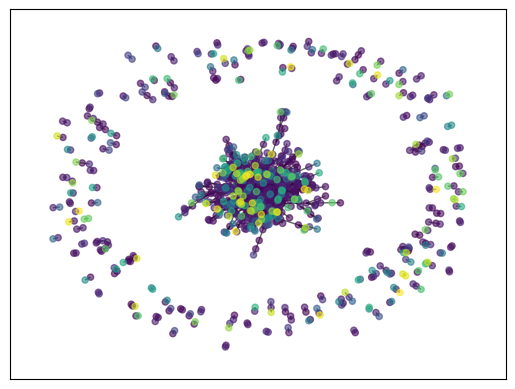

In [ ]:
g_new = nx.configuration_model(list(dict(g.degree()).values()), create_using=nx.Graph())
g_new = nx.Graph(g_new)
plot_communities(g_new)

### Quetion 3(a)

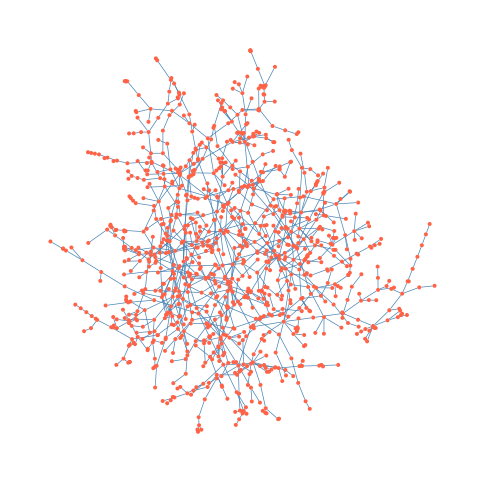

Power law exponent: 2.73604082848449


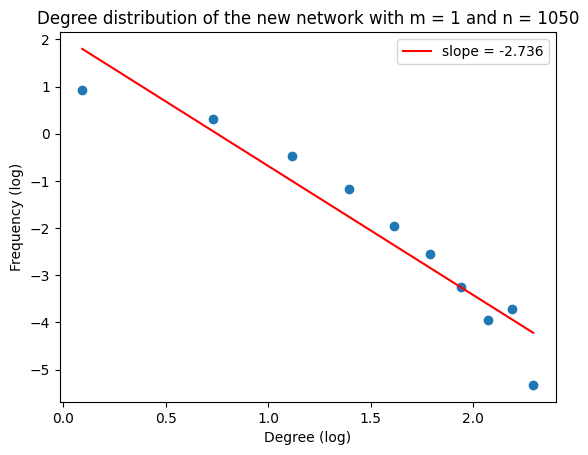

In [ ]:
import numpy as np
import igraph as ig
import random
import matplotlib.pyplot as plt
from scipy.stats import linregress

def sample_pa_age(n, m, pa_exp=1, aging_exp=-1, directed=False):
    g = ig.Graph()
    g.add_vertices(n)

    for i in range(m):
        g.add_edge(i, m)

    for i in range(m + 1, n):
        degrees = g.degree(range(i))
        ages = [i - x for x in range(i)]

        pa_probs = [d ** pa_exp for d in degrees]
        aging_probs = [a ** aging_exp for a in ages]

        total_probs = [pa * ag for pa, ag in zip(pa_probs, aging_probs)]
        total_probs_sum = sum(total_probs)
        normalized_probs = [p / total_probs_sum for p in total_probs]

        selected_nodes = random.choices(range(i), weights=normalized_probs, k=m)
        for node in selected_nodes:
            g.add_edge(i, node)

    return g

def plot_network(g):
    layout = g.layout("fr")  # Fruchterman-Reingold layout

    fig, ax = plt.subplots(figsize=(6, 6))
    ig.plot(
        g,
        target=ax,
        layout=layout,
        vertex_size=4,
        vertex_color="tomato",
        vertex_frame_width=0,
        edge_color="steelblue",
        edge_width=0.5,
        bbox=(700, 700),
        margin=25,
    )
    plt.show()

def plot_degree_distribution(g, m, n):
    degrees = g.degree()
    frequency, bin_edges = np.histogram(degrees, bins='auto', density=True)

    non_zero_indices = frequency > 0
    frequency = frequency[non_zero_indices]
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    bin_centers = bin_centers[non_zero_indices]

    bin_centers = np.log(bin_centers)
    frequency = np.log(frequency)

    plt.plot(bin_centers, frequency, marker='o', linestyle='none')

    para = np.polyfit(bin_centers, frequency, 1)
    p = np.poly1d(para)
    plt.plot(bin_centers, p(bin_centers), color='r', label=f"slope = {para[0]:.3f}")

    slope, _, _, _, _ = linregress(bin_centers, frequency)
    print("Power law exponent:", -slope)

    plt.xlabel('Degree (log)')
    plt.ylabel('Frequency (log)')
    plt.title(f"Degree distribution of the new network with m = {m} and n = {n}")
    plt.legend()
    plt.show()

# Parameters
n = 1050
m = 1
pa_exp = 1
aging_exp = -1
directed = False

# Generate and plot network
g = sample_pa_age(n, m, pa_exp, aging_exp, directed)
plot_network(g)
plot_degree_distribution(g, m, n)

### Quetion 3(b)

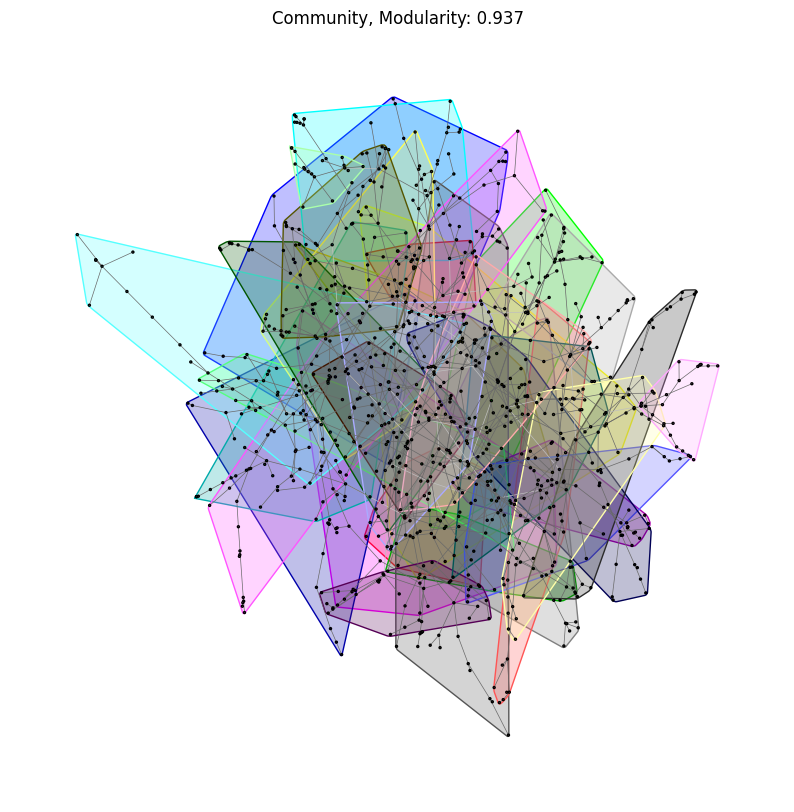

In [ ]:
# Run community detection
fg_new = g.community_fastgreedy()
communities = fg_new.as_clustering()
modularity = g.modularity(fg_new.as_clustering())

# Prepare layout for better visualization
layout = g.layout("fr")  # Fruchterman-Reingold layout

# Plot setup
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title(f"Community, Modularity: {modularity:.3f}")

# Draw graph with layout
ig.plot(
    communities,
    target=ax,
    layout=layout,
    vertex_size=2,
    edge_width=0.5,
    mark_groups=True
)

plt.show()

## 2. Random Walk on Networks

### Quetion 1(a)

<ipython-input-155-5524f64584d5>:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


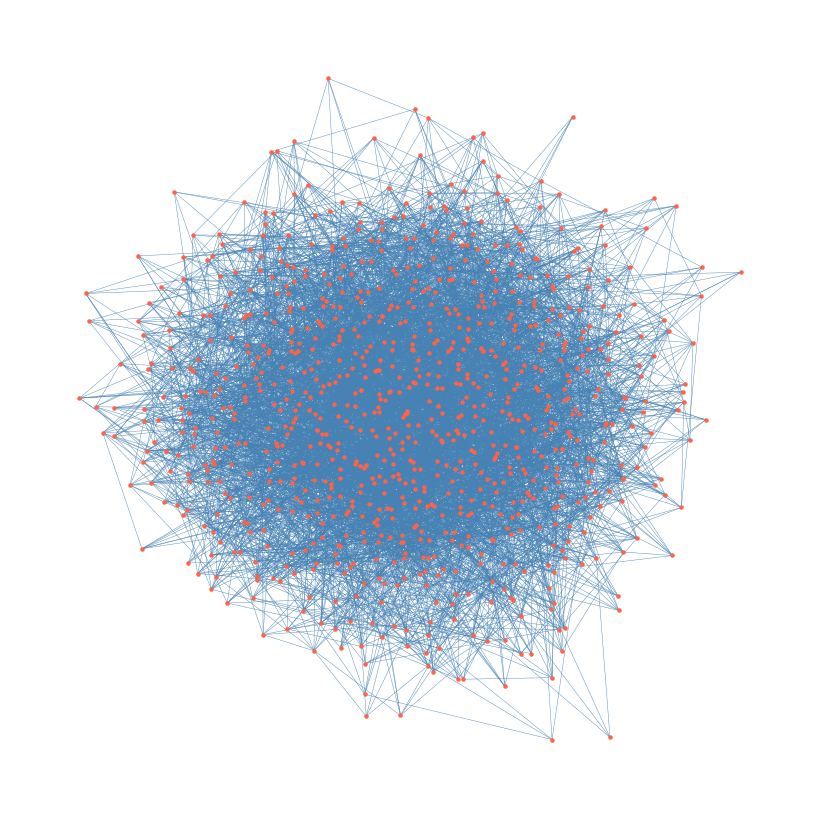

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random

# Graph parameters
num = 900
p = 0.015

# Graph set up
G = nx.Graph()
G.add_nodes_from(range(num))

# Edges
for i in range(num):
    for j in range(i + 1, num):
        rand_prob = random.random()
        if rand_prob < p:
            G.add_edge(i, j)


# Drawing the graph with improved style
plt.figure(figsize=(8, 8))
nx.draw(
    G,
    node_size=5,
    node_color="tomato",
    edge_color="steelblue",
    width=0.3,
    with_labels=False,
)

plt.axis("off")
plt.tight_layout()
plt.show()

### Quetion 1(b)

In [ ]:
def obtgcc(G):
    # Find connected components
    connected_components = nx.connected_components(G)
    # Get the Giant Connected Component (GCC)
    gcc_nodes = max(connected_components, key=len)
    gcc = G.subgraph(gcc_nodes).copy()  # Create a subgraph with GCC nodes
    return gcc
def random_walk(G, t=100, iterations=100):
    T = np.zeros(t)
    Path_length = np.zeros((t, iterations))
    Degree_nd = np.zeros((t, iterations))

    gcc = obtgcc(G)
    for i in range(t):
        T[i] = i + 1
        for j in range(iterations):
            random_node = random.choice(list(G.nodes()))
            O_node = random.choice(list(gcc.nodes()))
            walk = nx.single_source_shortest_path_length(gcc, O_node, cutoff=i+1)
            D_node = random.choice(list(walk.keys()))
            path_length = walk[D_node] if D_node in walk else np.inf
            degree_d = gcc.degree(D_node)
            Path_length[i, j] = path_length
            Degree_nd[i, j] = degree_d
    return T, Path_length, Degree_nd

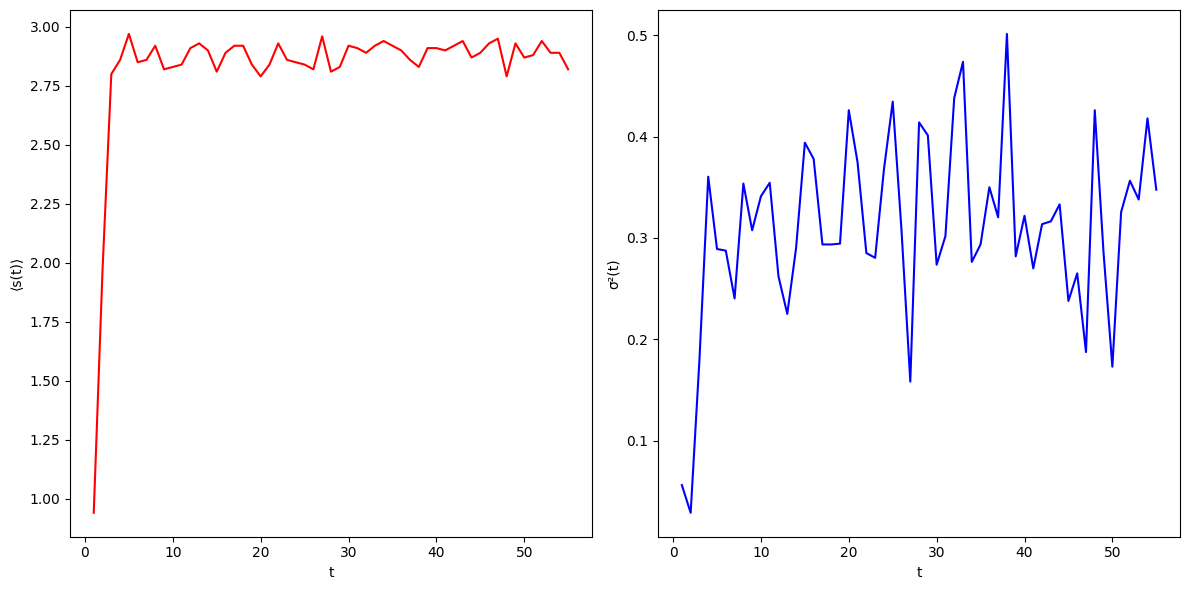

In [ ]:
T, Path_length, Degree_nd = random_walk(G, t=55, iterations=100)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Average distance
avelen = np.average(Path_length, axis=1)
axs[0].plot(T, avelen, color='r')
axs[0].set_xlabel('t')
axs[0].set_ylabel('⟨s(t)⟩')

# Variance
varlen = np.var(Path_length, axis=1)
axs[1].plot(T, varlen, color='b')
axs[1].set_xlabel('t')
axs[1].set_ylabel('σ²(t)')

# Adjustment
plt.tight_layout()
plt.show()

1.	The plot of ⟨s(t)⟩ versus t is shown on the left. Initially, ⟨s(t)⟩ increases, and over time, it stabilizes and tends to fluctuate below a value of 3.

2.	On the right is the plot of $\sigma_2(t)$ versus t. While the overall trend of $\sigma_2(t)$ resembles that of ⟨s(t)⟩, its variations are more erratic. The curve of $\sigma_2(t)$ exhibits greater fluctuations and less stability compared to ⟨s(t)⟩.

### Quetion 1(c)

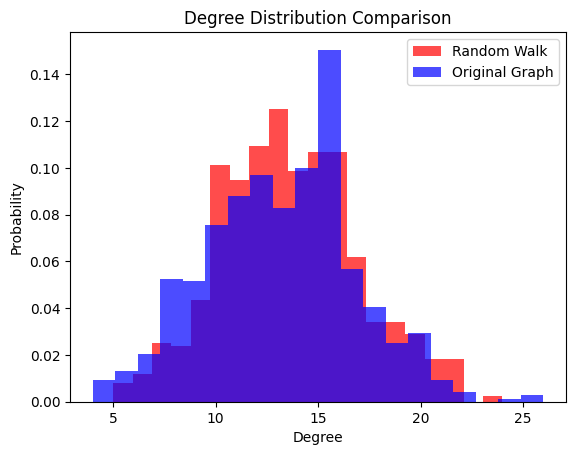

In [ ]:
# Degrees
degree_sequence_original = [d for n, d in G.degree()]
# histogram plot
plt.hist(Degree_nd[47:].flatten(), bins=20, density=True, alpha=0.7, color='r', label='Random Walk')
plt.hist(degree_sequence_original, bins=20, density=True, alpha=0.7, color='b', label='Original Graph')
plt.title('Degree Distribution Comparison')
plt.xlabel('Degree')
plt.ylabel('Probability')
plt.legend()
plt.show()

Based on the graph above, the original graph shows higher probabilities for node degrees in the ranges 10-13, 15-17, and above 21. In contrast, the random walk distribution tends to dominate in the other degree ranges. However, we observed that these patterns can vary depending on how the graph is generated.

### Quetion 1(d)

In [ ]:
G_large = nx.fast_gnp_random_graph(9000, 0.015)
(T,Pathlength,Degree_nd) = random_walk(G_large,t = 55,iterations = 100)

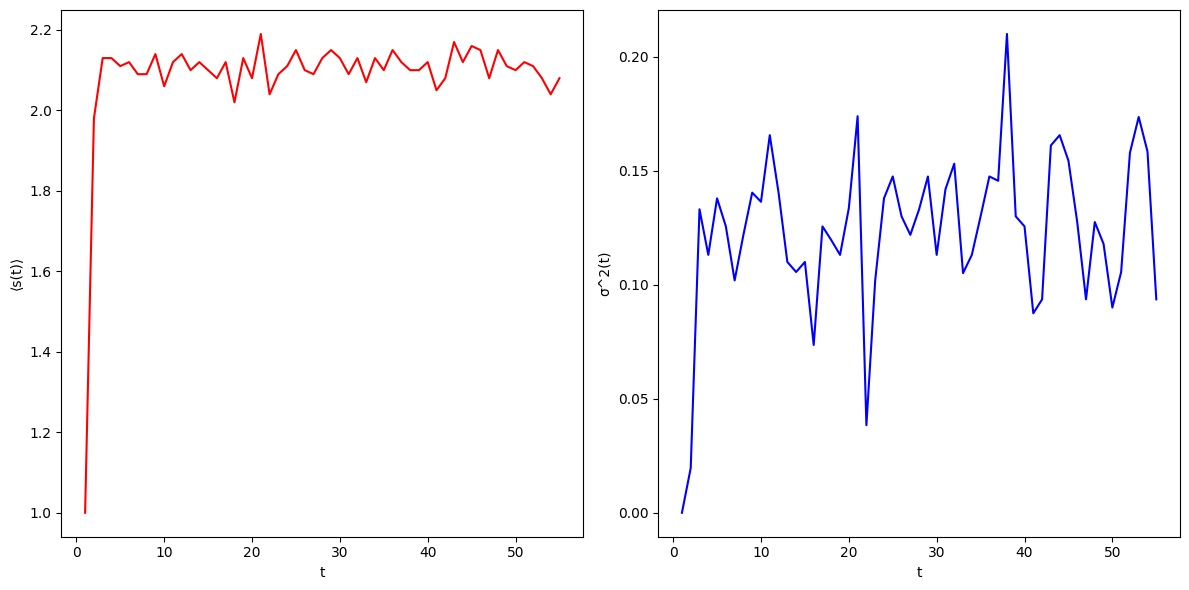

In [160]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
# Average distance
avelen = np.average(Pathlength, axis=1)
axs[0].plot(T, avelen, color='r')
axs[0].set_xlabel('t')
axs[0].set_ylabel('⟨s(t)⟩')
# Variance
varlen = np.var(Pathlength, axis=1)
axs[1].plot(T, varlen, color='b')
axs[1].set_xlabel('t')
axs[1].set_ylabel('σ^2(t)')
# Adjustment
plt.tight_layout()
plt.show()

**Answer:** \\
When repeating the experiment on an undirected random network with 9000 nodes, we observe several key differences compared to smaller networks. First, the curves for both ⟨s(t)⟩ and σ²(t) become noticeably more stable. This increased stability arises because larger networks tend to approximate the behavior of continuous systems, where random walks exhibit more predictable and averaged behavior across iterations. Second, the rate at which ⟨s(t)⟩ increases is slightly higher in the 9000-node network. This is likely due to the greater number of nodes and potential connections, which results in longer average path lengths and thus a more gradual exploration of the network over time.

The diameter of the network—representing the maximum shortest-path distance between any two nodes—also plays a crucial role in this behavior. A smaller diameter implies a more tightly connected graph, allowing a random walker to reach any node in fewer steps. As a result, the walker achieves a steady-state distribution more quickly. In our larger network, the reduced diameter means that the walker is generally never more than 2–3 hops away from any point in the network, compared to a diameter of 5 in the original graph. This faster convergence leads to a lower steady-state value of ⟨s(t)⟩ and a reduction in variance, since the walk consistently explores the network in a uniform manner across different runs.

### Quetion 2(a)

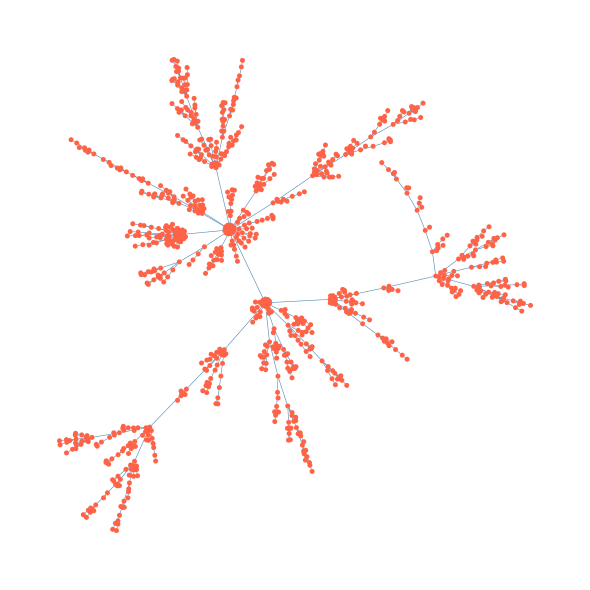

In [161]:
import igraph as ig
import matplotlib.pyplot as plt


G = ig.Graph.Barabasi(900, 1, directed=False)


layout = G.layout("fr")


fig, ax = plt.subplots(figsize=(6, 6))
ig.plot(
    G,
    target=ax,
    layout=layout,
    vertex_size=5,
    vertex_color="tomato",
    vertex_frame_width=0,
    edge_color="steelblue",
    edge_width=0.4,
    bbox=(500, 500),
    margin=20,
)

plt.tight_layout()
plt.show()

### Quetion 2(b)

In [162]:
# initialization
T = 500      # walk T times
S = 5000     # each walk, walk step S
N = 900

starter = np.random.randint(0, N - 1, size=(T,))
distances = np.zeros((T, S))  # ⟨s(t)⟩ will be stored here

# Random walk
for i in range(T):
    rst = G.random_walk(G.vs[starter[i]], S)[1:]
    paths = G.get_shortest_paths(G.vs[starter[i]], rst, mode='all')
    s_t = []  # holds ⟨s(t)⟩ per walk
    for j in range(S):
        s_t.append(len(paths[j]) - 1)
    distances[i] = np.array(s_t)  # ⟨s(t)⟩

# Calculation
avg_s = np.mean(distances, axis=0)   # ⟨s(t)⟩
sigma2 = np.var(distances, axis=0)   # σ²(t)

Number of nodes = 900


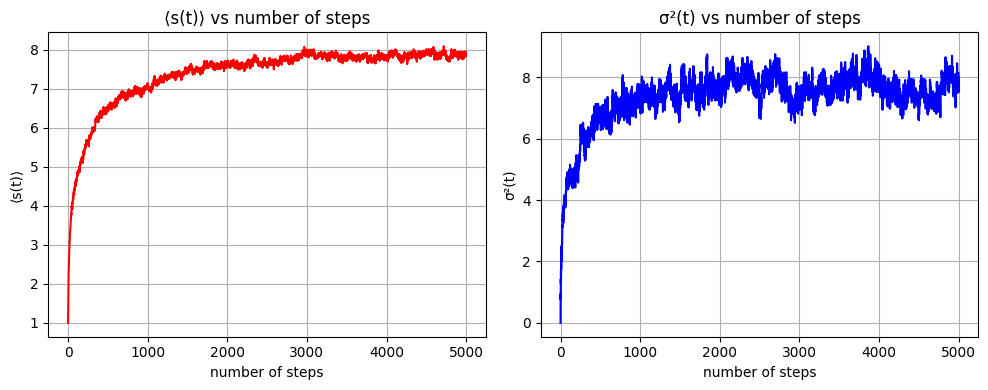

In [163]:
# imshow
print(f"Number of nodes = {N}")

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('⟨s(t)⟩ vs number of steps')
plt.plot(range(S), avg_s, color="r")
plt.xlabel('number of steps')
plt.ylabel('⟨s(t)⟩')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('σ²(t) vs number of steps')
plt.plot(range(S), sigma2, color="b")
plt.xlabel('number of steps')
plt.ylabel('σ²(t)')
plt.grid(True)

plt.tight_layout()
plt.show()

### Quetion 2(c)

In [164]:
T = 500
S = 5000
starter = np.random.randint(0, N - 1, size=(T,))  # T random starter
r = []

for i in range(T):
    # walk T times, add last node degree to r
    rst = G.random_walk(G.vs[starter[i]], S)
    r.append(G.degree(rst[-1]))

degrees = G.degree()

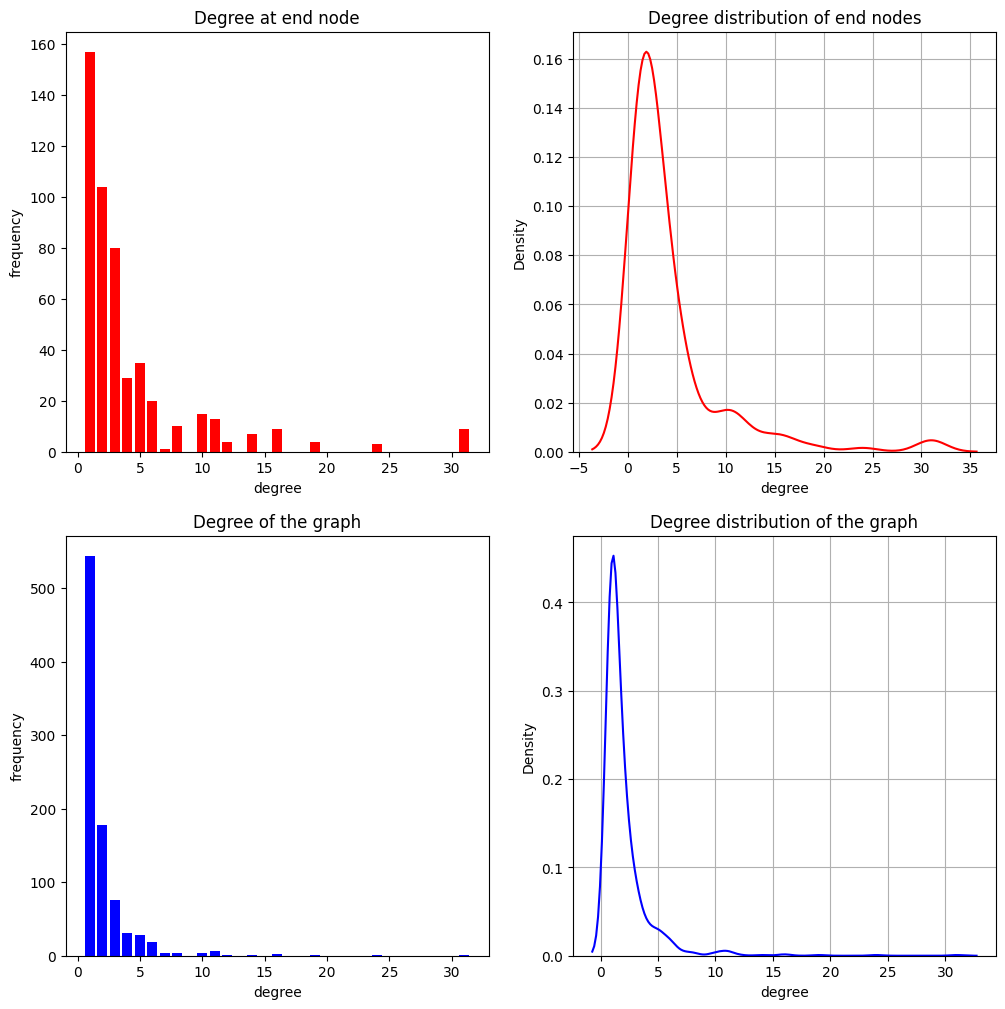

In [168]:
import seaborn as sns
plt.figure(figsize=(12, 12))

# End nodes' illustration
plt.subplot(2, 2, 1)
plt.title("Degree at end node")
plt.hist(r, bins=range(min(r), max(r) + 2), align='left', rwidth=0.8, density=False, color='r')
plt.xlabel('degree')
plt.ylabel('frequency')

plt.subplot(2, 2, 2)
plt.title("Degree distribution of end nodes")
sns.kdeplot(r, color='r')
plt.xlabel('degree')
plt.grid(True)

# Graph
plt.subplot(2, 2, 3)
plt.title("Degree of the graph")
plt.hist(degrees, bins=range(min(degrees), max(degrees) + 2), align='left', rwidth=0.8, density=False, color='b')
plt.xlabel('degree')
plt.ylabel('frequency')

plt.subplot(2, 2, 4)
plt.title("Degree distribution of the graph")
sns.kdeplot(degrees, color='b')
plt.xlabel('degree')
plt.grid(True)

plt.show()

**Answer:** \\
From the plots above, we observe that the overall degree distribution of the graph has a steeper slope, indicating that the degrees of the end nodes from the random walks are more concentrated around average values. This occurs because the random walk process is biased toward high-degree nodes, making it more likely to visit them more frequently.

### Quetion 2(d)

Number of nodes = 90


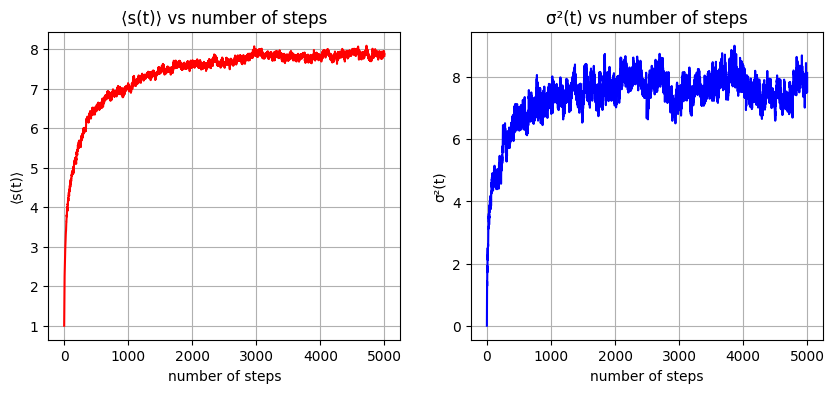

In [171]:
# Graph with 90 nodes
G = ig.Graph.Barabasi(90, 1, directed=False)

# initialization
T = 500      # walk T times
S = 5000     # walk step S
N = 90

starter = np.random.randint(0, N - 1, size=(T,))
distances = np.zeros((T, S))

# Random walk
for i in range(T):
    rst = G.random_walk(G.vs[starter[i]], S)[1:]
    paths = G.get_shortest_paths(G.vs[starter[i]], rst, mode='all')
    distance = []
    for j in range(S):
        distance.append(len(paths[j]) - 1)
    distances[i] = np.array(distance)

# Calculation
avg_distance = np.mean(distances, axis=0)
var = np.var(distances, axis=0)

# imshow
print(f"Number of nodes = {N}")

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('⟨s(t)⟩ vs number of steps')
plt.plot(range(S), avg_s, color="r")
plt.xlabel('number of steps')
plt.ylabel('⟨s(t)⟩')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('σ²(t) vs number of steps')
plt.plot(range(S), sigma2, color="b")
plt.xlabel('number of steps')
plt.ylabel('σ²(t)')
plt.grid(True)

plt.show()

Number of nodes = 9000


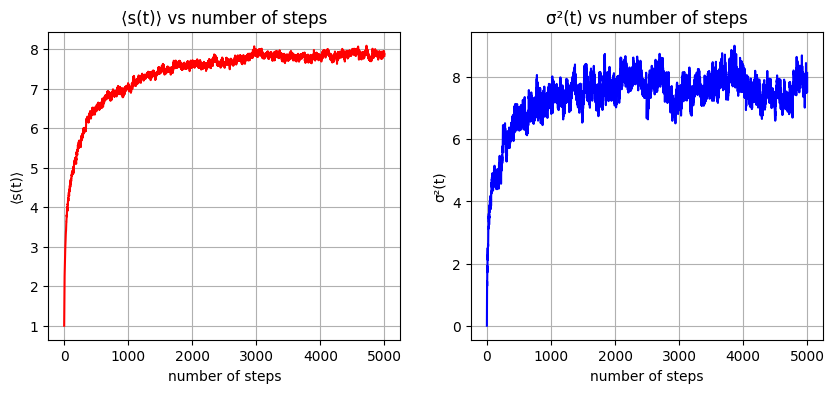

In [172]:
# Graph with 9000 nodes
G = ig.Graph.Barabasi(9000, 1, directed=False)

# initialization
T = 500      # walk T times
S = 5000     # walk step S
N = 9000

starter = np.random.randint(0, N - 1, size=(T,))
distances = np.zeros((T, S))

# Random walk
for i in range(T):
    rst = G.random_walk(G.vs[starter[i]], S)[1:]
    paths = G.get_shortest_paths(G.vs[starter[i]], rst, mode='all')
    distance = []
    for j in range(S):
        distance.append(len(paths[j]) - 1)
    distances[i] = np.array(distance)

# Calculation
avg_distance = np.mean(distances, axis=0)
var = np.var(distances, axis=0)

# imshow
print(f"Number of nodes = {N}")

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('⟨s(t)⟩ vs number of steps')
plt.plot(range(S), avg_s, color="r")
plt.xlabel('number of steps')
plt.ylabel('⟨s(t)⟩')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('σ²(t) vs number of steps')
plt.plot(range(S), sigma2, color="b")
plt.xlabel('number of steps')
plt.ylabel('σ²(t)')
plt.grid(True)

plt.show()

The curves above highlight two key differences: \\
	1.	In smaller networks, both the average distance and variance reach a stable state more quickly. This is because with fewer nodes, random walkers encounter the network's boundaries sooner, requiring fewer steps to explore the graph. \\
	2.	Once the values stabilize, the fluctuations in larger networks are less intense. This is likely due to the increased number of nodes, which makes it harder for small changes to significantly impact the number of steps taken. \\

In summary, the network's diameter does influence the behavior of random walks. A larger diameter results in a slower rise in both the average distance and variance, but once stabilized, these metrics tend to fluctuate less.

### Quetion 3(a)

In [173]:
# graph generation
# 900 nodes, m=4
N = 900
G = ig.Graph.Barabasi(N, 4, directed=True)
Gb = ig.Graph.Barabasi(N, 4, directed=True)

# edges addition
edges = np.array(Gb.get_edgelist())
shumap = np.arange(N)
np.random.shuffle(shumap)
added = shumap[edges]
G.add_edges(added)

# random walk
T = 1000
starter = np.random.randint(0, N-1, size=(T,))
R = []
for i in range(1000):
    R.append(G.random_walk(G.vs[starter[i]], T)[1:])

In [177]:
from collections import Counter
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np

def imgshow(rst_ori, g, observe='all', mode='in-degree', **kwargs):
    N = g.vcount()
    rst = []
    for r in rst_ori:
        if observe == "all":
            rst += r
        elif observe == "last":
            rst.append(r[-1])

    # probability calculation
    visit_counter = Counter(rst)
    p_visited = np.zeros(N)
    for i in range(N):
        p_visited[i] = visit_counter[i]
    p_visited /= len(rst)

    # get metric
    if mode == "degree":
        metric = np.array(g.degree(mode='all'))
    elif mode == "in-degree":
        metric = np.array(g.degree(mode='in'))
    elif mode == "pagerank":
        metric = np.array(ig.Graph.pagerank(g, damping=0.8))
    elif mode == "personalized_pagerank":
        metric = np.array(ig.Graph.personalized_pagerank(g, damping=0.8, reset_vertices=kwargs['nodes']))
    else:
        metric = mode

    # compute correlation
    print("Correlation:", stats.pearsonr(p_visited, metric))  # Correlation

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title(f'visiting probability vs {mode}')
    plt.xlabel(mode)
    plt.ylabel('visiting probability')
    plt.grid(True)
    plt.scatter(metric, p_visited, color="blue", facecolors='none')

    # Regression fit
    para = np.polyfit(metric, p_visited, 1)
    p = np.poly1d(para)
    x = np.arange(100) / 100 * np.max(metric)
    plt.xlabel(f'vertex {mode}')
    plt.plot(x, p(x), color='r')

    # Mean-group smoothing
    for i in range(50):
        mask = np.where(metric == i, 1, 0)
        count = np.sum(mask)
        if count == 0:
            continue
        p = np.sum(mask * p_visited) / count
        p_visited = p_visited * (1 - mask) + p * mask

    # Log-log version
    plt.subplot(1, 2, 2)
    plt.title(f'log visiting probability vs log {mode}')
    plt.xlabel(f"log {mode}")
    plt.ylabel('log visiting probability')
    plt.yscale('log')
    plt.xscale('log')
    plt.scatter(metric, p_visited, color="blue", facecolors='none')
    plt.grid(True)
    plt.show()

Correlation: PearsonRResult(statistic=np.float64(0.9179250314216277), pvalue=np.float64(0.0))


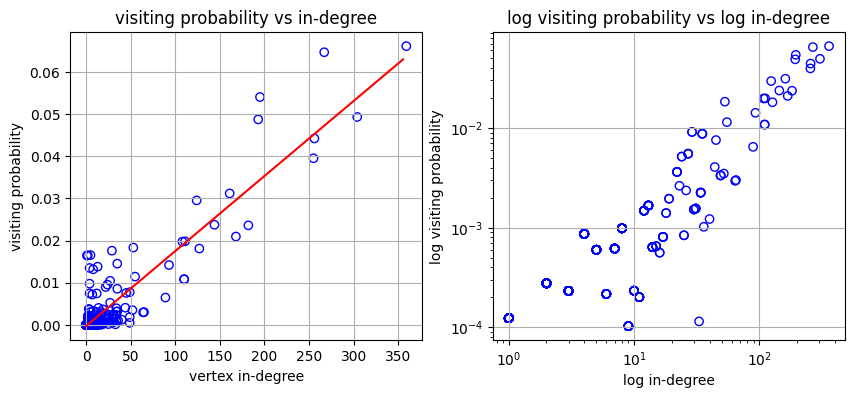

In [178]:
imgshow(R, G)

In this experiment, we measured the visiting probability of each node during a random walk process. This probability, stored in the variable p_visited, reflects how often a node is visited by a random walker across multiple walks. \\
To determine whether this probability is related to node degree, we compared p_visited against the degree of each node. The analysis reveals a positive correlation: \\
	1.	Visual Evidence: From the scatter plot, we observe that as the degree of a node increases, the probability of being visited also increases. \\
	2.	Quantitative Analysis: The Pearson correlation coefficient between degree and visiting probability is approximately 0.918, indicating a strong linear relationship. \\
	3.	Intuitive Interpretation: Higher-degree nodes are connected to more neighbors, making them more accessible during the walk, and thus more likely to be visited. \\
To ensure that the network allowed proper connectivity and avoided isolated or poorly connected nodes (i.e., “black holes”), we generated two directed preferential attachment graphs, randomly permuted one of them, and added it to the original graph. This guarantees a strongly connected directed structure where any node is reachable. \\
Instead of simulating full PageRank (with teleportation), we used a vanilla PageRank approach via random walks. Since the number of steps needed to reach steady state is logarithmic in the number of nodes (i.e., ~ln(n)), we simplified the process by only recording the last node visited at the end of each walk of length n. This provides a good approximation of steady-state behavior without requiring full convergence.

### Quetion 3(b)

In [179]:
def get_transition_probs(G):
    N = G.vcount()
    # generate transition probs
    transition_probs = [[0] * N for i in range(N)]
    for i in range(N):
        neighbors = G.neighbors(i, mode='out')
        assert len(neighbors) > 0
        for j in neighbors:
            transition_probs[i][j] = 1.0 / G.degree(i, mode='out')
    return transition_probs

In [180]:
def escapable_random_walk(transition_probs, start=0, T=1000, pout=0.2):
    # walk T times
    R = [start]
    current_node = start
    for i in range(T):
        if random.random() < pout:
            return R
        else:
            probs = transition_probs[current_node]
            next_node = random.choices(range(N), probs)[0]
            current_node = next_node
            R.append(current_node)
    return RuntimeError

Correlation: PearsonRResult(statistic=np.float64(0.9502481700344211), pvalue=np.float64(0.0))


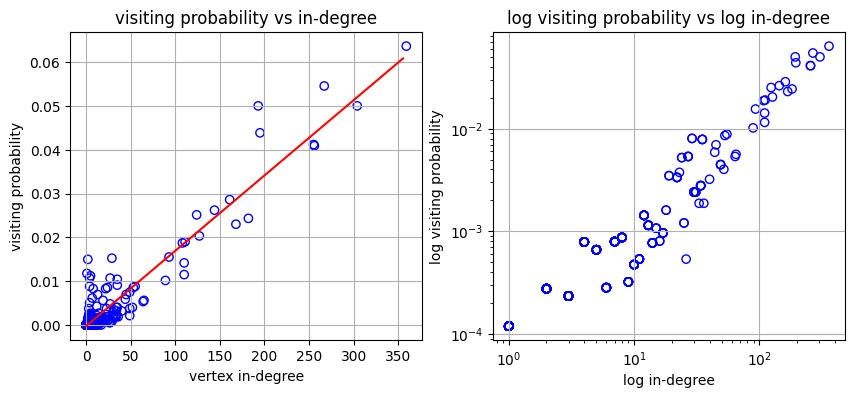

In [185]:
# walk with probability of teleportation
T = 1000
pout = 0.2
transition_probs = get_transition_probs(G)
starter = np.random.randint(0, N-1, size=(T,))
R = []
for i in range(T):
    R.append(escapable_random_walk(transition_probs, starter[i], T, pout)[1:])
imgshow(R, G)

Correlation: PearsonRResult(statistic=np.float64(0.9550878948511439), pvalue=np.float64(0.0))


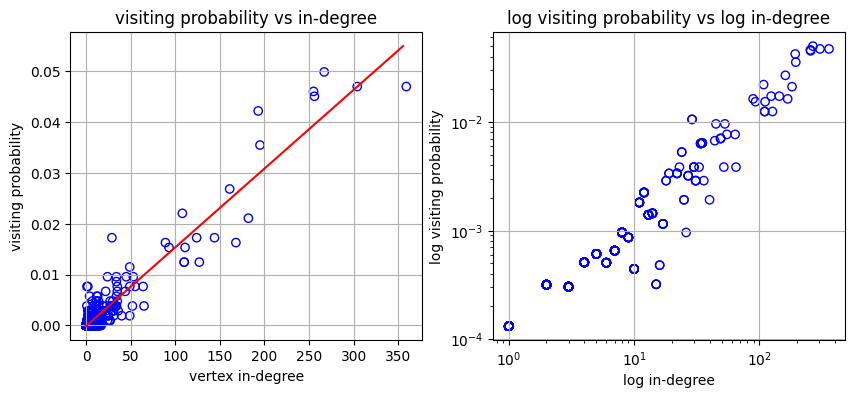

In [188]:
# walk with probability of teleportation
T = 1000
pout = 0.5
transition_probs = get_transition_probs(G)
starter = np.random.randint(0, N-1, size=(T,))
R = []
for i in range(T):
    R.append(escapable_random_walk(transition_probs, starter[i], T, pout)[1:])
imgshow(R, G)

Correlation: PearsonRResult(statistic=np.float64(0.9204827541313673), pvalue=np.float64(0.0))


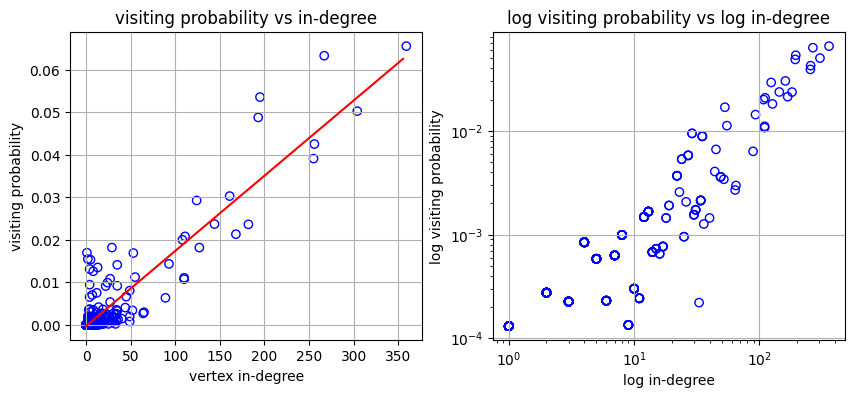

In [189]:
pout = 0.02
transition_probs = get_transition_probs(G)
starter = np.random.randint(0, N-1, size=(T,))
R = []
for i in range(T):
    R.append(escapable_random_walk(transition_probs, starter[i], T, pout)[1:])
imgshow(R, G)

**Answer:** \\
In this experiment, we examined the relationship between node degree and visiting probability. Statistically, we observed that nodes with higher degrees tend to have higher probabilities of being visited. Qualitatively, this makes sense since high-degree nodes are connected to more neighbors, making them more accessible during random walks. We further explored this by introducing teleportation with three different probabilities (α = 0.02, 0.2, and 0.5). As α increased, the correlation between node degree and visiting probability also became stronger. This is because nodes with higher degrees typically have more outgoing links, increasing their chances of being selected during teleportation. As a result, teleportation tends to reinforce the advantage of high-degree nodes, making them even more likely to be visited as α grows.

### Quetion 4(a)

In [190]:
def pagerank_transition_probs(g):
    N = g.vcount()
    pagerank_score = ig.Graph.pagerank(g, damping=0.8)

    # generate transition probs
    transition_probs = [[0] * N for i in range(N)]
    for i in range(N):
        neighbors = g.neighbors(i, mode='out')
        assert len(neighbors) > 0
        for j in neighbors:
            transition_probs[i][j] = pagerank_score[j]
    return transition_probs

In [191]:
def personalized_random_walk(transition_probs, start=0, T=1000, pout=0.2):
    # walk T times
    rst = [start]
    current_node = start
    for i in range(T):
        if random.random() < pout:
            next_node = random.randint(0, N - 1)
        else:
            probs = transition_probs[current_node]
            next_node = random.choices(range(N), probs)[0]
        current_node = next_node
        rst.append(current_node)
    return rst

In [192]:
# walk with probability of teleportation
G1 = G
T = 1000
pout = 0.2
per_transition_probs = pagerank_transition_probs(G1)
starter = np.random.randint(0, N - 1, size=(T,))  # T random starter
R1 = []
for i in range(T):
    # walk T times, add visited vertices to rst, except the starter
    R1.append(personalized_random_walk(per_transition_probs, starter[i], T, pout)[1:])

Correlation: PearsonRResult(statistic=np.float64(0.8693005316283747), pvalue=np.float64(4.750397679739814e-277))


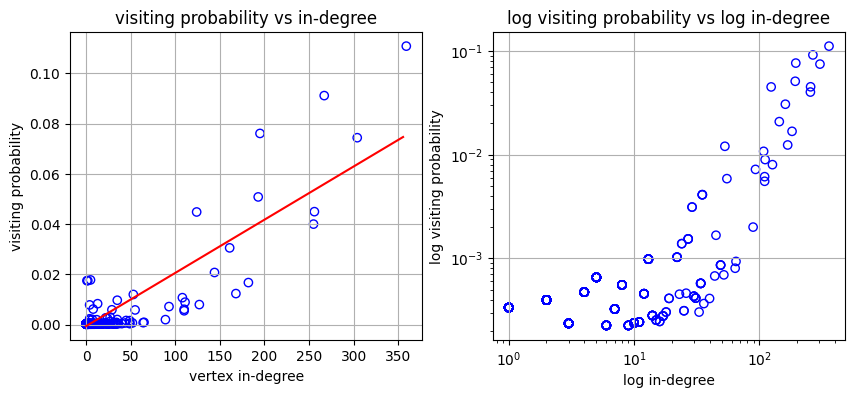

Correlation: PearsonRResult(statistic=np.float64(0.9434485981047399), pvalue=np.float64(0.0))


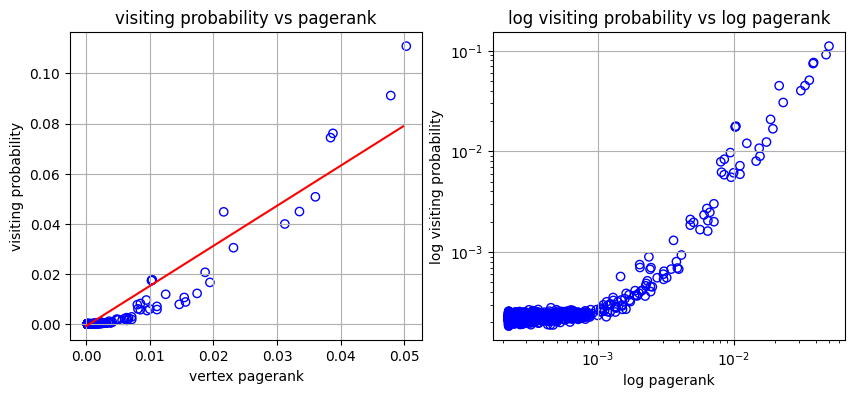

In [193]:
imgshow(R1, G1)
imgshow(R1, G1, mode='pagerank')

**Answer:** \\
Comparison with 3(a): \\
	1.	Statistical Insight: The correlation between visiting probability and node degree is significantly weaker compared to the correlation with PageRank. This suggests that PageRank is a better predictor of how often a node is visited. \\
	2.	Qualitative Reasoning: This occurs because, during random walks, we tend to visit nodes that are more influential or central rather than selecting nodes uniformly at random. Personalized PageRank introduces a bias toward higher-ranked nodes, making them more likely to be visited as they are perceived as more important within the network.

### Quetion 4(b)

In [194]:
def personalizedWalk(transition_probs, start=0, T=1000, pout=0.2, outnodes=[0, 1]):
    R = [start]
    current_node = start
    for i in range(T):
        if random.random() < pout:
            next_node = outnodes[random.randint(0, 1)]
        else:
            probs = transition_probs[current_node]
            next_node = random.choices(range(N), probs)[0]
        current_node = next_node
        R.append(current_node)
    return R

In [195]:
# walk with prob of teleportation
T = 1000
pout = 0.2
per_transition_probs = pagerank_transition_probs(G1)
starter = np.random.randint(0, N - 1, size=(T,))  # T random starter

In [196]:
R2 = []

# find median index
pagerank_score = ig.Graph.pagerank(G1, damping=0.8)
node1 = np.argsort(pagerank_score)[(N - 1) // 2]
node2 = np.argsort(pagerank_score)[(N + 1) // 2]

print(node1, node2)
print(f"Regarding pagerank values: {pagerank_score[node1]},{pagerank_score[node2]}")

for i in range(T):
    # walk T times, add visited vertices to rst, except for the starter
    R2.append(personalizedWalk(per_transition_probs, starter[i], T, pout, outnodes=[node1, node2])[1:])

686 428
Regarding pagerank values: 0.0002729558890084795,0.0002733333333339192


Correlation: PearsonRResult(statistic=np.float64(0.7595630687298889), pvalue=np.float64(6.317779784151257e-170))


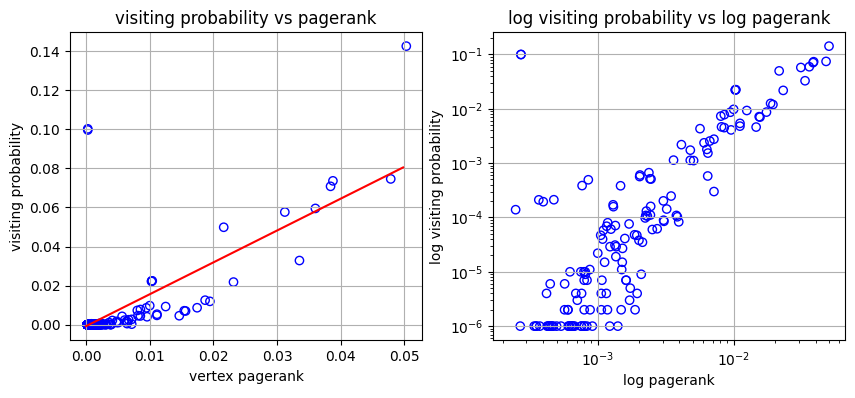

In [197]:
imgshow(R2, G1, mode='pagerank')

Compared to the results in part 4(a), a noticeable difference emerges when nodes have medium-level PageRank values: \\

1.	Statistical Observation: Nodes with medium PageRank scores exhibit significantly higher visiting probabilities than those in part 4(a). \\

2.	Qualitative Explanation: This is because these nodes are the exclusive targets for teleportation, which increases their likelihood of being visited. As a result, their PageRank scores also rise accordingly, as discussed earlier.

### Quetion 4(c)

### Question 4c: Personalized PageRank with a Trusted Set

In this task, we extend the standard PageRank algorithm to model user behavior that only teleports to a specific set of trusted nodes, rather than uniformly to all nodes as in the original approach.

The **vanilla PageRank** is defined as:

$
\pi(i) = \sum_{j=1}^{|V|} \frac{A_{ji}}{\text{degree}(vertex_j)} \pi(j)
\tag{1}
$

To incorporate teleportation, the algorithm is modified as:

$
\pi(i) = (1 - \alpha) \sum_{j=1}^{|V|} \frac{A_{ji}}{\text{degree}(vertex_j)} \pi(j) + \frac{\alpha I(i)}{|M|}
\tag{2}
$

where

$
I(i) =
\begin{cases}
1, & i \in M \\
0, & i \notin M
\end{cases}
$

Here, teleportation occurs only to nodes in the trusted set \( M \), and nodes outside \( M \) receive no teleportation mass.

We further refine the model by applying different update rules based on whether a node is in the trusted set:

- For nodes $ i \in M $:
$
\pi(i) = (1 - \alpha) \sum_{j=1}^{|V|} \frac{A_{ji}}{\text{degree}(vertex_j)} \pi(j) + \frac{\alpha}{|M|}
$

- For nodes $ i \notin M $:
$
\pi(i) = \sum_{j=1}^{|V|} \frac{A_{ji}}{\text{degree}(vertex_j)} \pi(j)
$

---

### Interpretation

This modification ensures that nodes in the trusted set \( M \) gain higher PageRank scores due to targeted teleportation. For all other nodes, the original PageRank rule applies, assuming no preference. This personalized scheme better captures user behavior in applications like trust-based recommendations, authority identification, or topic-specific browsing.

In [198]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 libapache-pom-java
  libcmark-gfm-extensions0.29.0.gfm.3 libcmark-gfm0.29.0.gfm.3
  libcommons-logging-java libcommons-parent-java libfontbox-java libgs9
  libgs9-common libidn12 libijs-0.35 libjbig2dec0 libkpathsea6 libpdfbox-java
  libptexenc1 libruby3.0 libsynctex2 libteckit0 libtexlua53 libtexluajit2
  libwoff1 libzzip-0-13 lmodern pandoc-data poppler-data preview-latex-style
  rake ruby ruby-net-telnet ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0
  rubygems-integration t1utils teckit tex-common tex-gyre texlive-base
  texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa
  xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/Colab\ Notebooks/

In [ ]:
!jupyter nbconvert "ece232e_project1.ipynb" --to PDF